# 三種資料切分策略實驗 (時間 / 環境 / Few-Shot)
本 Notebook 針對加工熱變位資料進行三種資料切分策略：
1. **時間切分 (Time-based)**：依照日期先後，前段做訓練、後段做測試
2. **環境切分 (Environment-based)**：使用恆溫 (控溫=恆溫) 作為訓練，變溫/其他條件做測試 (模擬 domain shift)
3. **Few-Shot Learning**：每種主要條件(依溫控+溫度)僅選極少量檔案訓練，其餘為測試 (低資料學習)

並使用 `model/thermal_displacement_prediction.py` 中的 `ThermalDisplacementPredictor` 訓練三種模型：
- Linear Regression
- Random Forest
- Gradient Boosting

最終彙整比較各策略下的 RMSE（X、Z、平均）。

> 資料來源：使用已截斷處理後的 `truncated_data`。若需改成原始請調整 BASE_DATA_DIR。

In [ ]:
# === 匯入套件與基本設定 ===
import os, glob, shutil, math, json
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
from collections import defaultdict

# 匯入既有模型類別
from model.thermal_displacement_prediction import ThermalDisplacementPredictor

BASE_DATA_DIR = '/Users/benjamin/1132/11325/AI_Race/truncated_data'  # 已時間截斷資料
CONDITION_FILE = '/Users/benjamin/1132/11325/AI_Race/檔案環境設定總表.csv'
EXPERIMENT_ROOT = '/Users/benjamin/1132/11325/AI_Race/experiments'
Path(EXPERIMENT_ROOT).mkdir(parents=True, exist_ok=True)

print('✅ Environment initialized')

✅ Environment initialized (with LinearRegression import)


In [46]:
# === 載入加工條件對照表 (手動合併前兩行欄位) ===
import csv

def load_condition_table(path: str):
    with open(path, 'r', encoding='utf-8') as f:
        reader = list(csv.reader(f))
    if len(reader) < 2:
        raise ValueError('檔案內容不足兩行')
    header1 = reader[0]
    header2 = reader[1]
    combined = []
    for h1, h2 in zip(header1, header2):
        h1c = h1.strip(); h2c = h2.strip()
        if h2c:
            if h1c:
                combined.append(f"{h1c}_{h2c}")
            else:
                combined.append(h2c)
        else:
            combined.append(h1c if h1c else '欄位')
    data_rows = reader[2:]
    df = pd.DataFrame(data_rows, columns=combined)
    date_col = None
    for c in df.columns:
        if '日期' in c:
            date_col = c; break
    if date_col is None:
        raise ValueError('找不到日期欄位')
    df.rename(columns={date_col: '日期'}, inplace=True)
    ctrl_col = None; temp_col = None
    for c in df.columns:
        if '控溫' in c: ctrl_col = c
        if c.endswith('溫度') or ('溫度' in c and '時間' not in c): temp_col = c
    if ctrl_col: df.rename(columns={ctrl_col: '控溫'}, inplace=True)
    if temp_col: df.rename(columns={temp_col: '溫度'}, inplace=True)
    df['日期'] = df['日期'].astype(str).str.strip()
    return df[['日期','控溫','溫度']] if all(col in df.columns for col in ['日期','控溫','溫度']) else df

condition_df = load_condition_table(CONDITION_FILE)
print(f'條件記錄數: {len(condition_df)}')
print('欄位:', condition_df.columns.tolist())
# 建立全域 map
env_map = condition_df.set_index('日期')['控溫'].to_dict()
combo_temp_map = condition_df.set_index('日期')['溫度'].to_dict()
condition_df.head()

條件記錄數: 56
欄位: ['日期', '控溫', '溫度']


日期  控溫  溫度
0  20200615  恆溫  25
1  20200616  恆溫  25
2  20200617  恆溫  25
3  20200618  恆溫  25
4  20200701  恆溫  20

In [47]:
# === 公用：列出所有已截斷資料檔案與日期對應 ===
def list_data_files(data_dir):
    files = sorted([f for f in glob.glob(os.path.join(data_dir, '*.csv')) if not f.endswith('truncation_report.csv')])
    records = []
    for fp in files:
        fname = os.path.basename(fp)
        # 檔名格式假設: _YYYYMMDD_...
        try:
            date_key = fname.split('_')[1]
        except Exception:
            date_key = ''
        records.append({'file_path': fp, 'filename': fname, 'date_key': date_key})
    return pd.DataFrame(records)

all_files_df = list_data_files(BASE_DATA_DIR)
print(f'資料檔案數: {len(all_files_df)}')
all_files_df.head()

資料檔案數: 43


file_path  \
0  /Users/benjamin/1132/11325/AI_Race/truncated_d...   
1  /Users/benjamin/1132/11325/AI_Race/truncated_d...   
2  /Users/benjamin/1132/11325/AI_Race/truncated_d...   
3  /Users/benjamin/1132/11325/AI_Race/truncated_d...   
4  /Users/benjamin/1132/11325/AI_Race/truncated_d...   

                                            filename  date_key  
0  _20200615_GV1-1203_2000rpm_XZ-5m-min_5H(wAC-fr...  20200615  
1  _20200616_GV1-1203_1000rpm_XZ-5m-min_5H(wAC-fr...  20200616  
2  _20200617_GV1-1203_1k+2krpm_XZ-5m-min_5H(wAC-f...  20200617  
3  _20200618_GV1-1203_2k+1krpm_XZ-5m-min_5H(wAC-f...  20200618  
4  _20200701_GV1-1203_2000rpm_XZ-5m-min_5H(wAC-fr...  20200701

In [48]:
# === 補強：6H 檔案只取前 5 小時 (Time <= 300) 產生新資料夾 truncated_data_5h ===
from pathlib import Path
orig_dir = Path(BASE_DATA_DIR)
output_dir = orig_dir.parent / 'truncated_data_5h'
output_dir.mkdir(exist_ok=True)

processed_report = []
for fp in all_files_df['file_path']:
    fname = os.path.basename(fp)
    df = pd.read_csv(fp)
    if '6H' in fname and 'Time' in df.columns:
        before_len = len(df)
        before_max_time = df['Time'].max()
        df_trunc = df[df['Time'] <= 300].copy()
        after_len = len(df_trunc)
        after_max_time = df_trunc['Time'].max() if len(df_trunc)>0 else None
        df_trunc.to_csv(output_dir / fname.replace('6H','5H_truncFrom6H'), index=False)
        processed_report.append({'file': fname,'type':'6H->5H','rows_before':before_len,'rows_after':after_len,'max_time_before':before_max_time,'max_time_after':after_max_time})
    else:
        # 5H 原樣複製 (或其他檔案維持)
        df.to_csv(output_dir / fname, index=False)
        processed_report.append({'file': fname,'type':'copy','rows_before':len(df),'rows_after':len(df),'max_time_before': df['Time'].max() if 'Time' in df.columns else None,'max_time_after': df['Time'].max() if 'Time' in df.columns else None})

report_df = pd.DataFrame(processed_report)
report_path = output_dir / 'five_hour_truncation_report.csv'
report_df.to_csv(report_path, index=False)
print(f'✅ 6H->5H truncation done. Output dir: {output_dir}')
print(report_df[report_df["type"]=='6H->5H'].head())

✅ 6H->5H truncation done. Output dir: /Users/benjamin/1132/11325/AI_Race/truncated_data_5h
                                                 file    type  rows_before  \
8   _20200708_GV1-1203_2000rpm_XZ-5m-min_6H(wAC-fr...  6H->5H          606   
9   _20200709_GV1-1203_1000rpm_XZ-5m-min_6H(wAC-fr...  6H->5H          609   
10  _20200710_GV1-1203_1k+2krpm_XZ-5m-min_6H(wAC-f...  6H->5H          608   
11  _20200713_GV1-1203_2k+1krpm_XZ-5m-min_6H(wAC-f...  6H->5H          609   
19  _20200813_GV1-1203_2000rpm_XZ-5m-min_6H(wAC-fr...  6H->5H         2138   

    rows_after  max_time_before  max_time_after  
8          516          360.365         299.704  
9          518          360.992         299.653  
10         517          360.656         299.332  
11         518          360.932         299.589  
19        1778          360.484         299.850  


In [49]:
# === 公用：建立目錄並複製檔案 (避免重複處理大檔，可選擇跳過已存在) ===
def prepare_split_folder(root, split_name):
    split_root = Path(root) / split_name
    (split_root / 'train').mkdir(parents=True, exist_ok=True)
    (split_root / 'test').mkdir(parents=True, exist_ok=True)
    return split_root

def copy_files(file_list, dest_dir, overwrite=False):
    for fp in file_list:
        fname = os.path.basename(fp)
        dest = Path(dest_dir) / fname
        if overwrite or (not dest.exists()):
            shutil.copy(fp, dest)

print('✅ Copy helpers ready')

✅ Copy helpers ready


In [50]:
# === 策略1：時間切分 (按日期排序 70% / 30%) ===

def time_based_split(files_df, train_ratio=0.7):
    df = files_df.copy()
    # 轉換日期排序 (若解析失敗則置後)
    def try_parse(d):
        try:
            return datetime.strptime(d, '%Y%m%d')
        except Exception:
            return datetime.max
    df['date_obj'] = df['date_key'].apply(try_parse)
    df = df.sort_values('date_obj')
    n = len(df)
    n_train = max(1, int(n * train_ratio))
    train_df = df.iloc[:n_train]
    test_df = df.iloc[n_train:]
    return train_df, test_df

# 執行
time_train_df, time_test_df = time_based_split(all_files_df, 0.7)
print(f"時間切分 -> Train: {len(time_train_df)}, Test: {len(time_test_df)}")

time_train_df.head()

時間切分 -> Train: 30, Test: 13


file_path  \
0  /Users/benjamin/1132/11325/AI_Race/truncated_d...   
1  /Users/benjamin/1132/11325/AI_Race/truncated_d...   
2  /Users/benjamin/1132/11325/AI_Race/truncated_d...   
3  /Users/benjamin/1132/11325/AI_Race/truncated_d...   
4  /Users/benjamin/1132/11325/AI_Race/truncated_d...   

                                            filename  date_key   date_obj  
0  _20200615_GV1-1203_2000rpm_XZ-5m-min_5H(wAC-fr...  20200615 2020-06-15  
1  _20200616_GV1-1203_1000rpm_XZ-5m-min_5H(wAC-fr...  20200616 2020-06-16  
2  _20200617_GV1-1203_1k+2krpm_XZ-5m-min_5H(wAC-f...  20200617 2020-06-17  
3  _20200618_GV1-1203_2k+1krpm_XZ-5m-min_5H(wAC-f...  20200618 2020-06-18  
4  _20200701_GV1-1203_2000rpm_XZ-5m-min_5H(wAC-fr...  20200701 2020-07-01

In [51]:
# === 策略2：環境切分 (恆溫做訓練，非恆溫做測試) ===

def environment_based_split(files_df):
    labels = []
    for _, row in files_df.iterrows():
        env = env_map.get(row['date_key'], '未知')
        labels.append(env)
    df = files_df.copy()
    df['env'] = labels
    train_df = df[df['env'] == '恆溫']
    test_df = df[df['env'] != '恆溫']
    if len(test_df) == 0:
        print('⚠️ 無非恆溫資料，退化為時間切分備援')
        t_train, t_test = time_based_split(files_df, 0.7)
        return t_train, t_test
    if len(train_df) < 2:
        print('⚠️ 恆溫訓練檔案過少，啟用備援時間切分')
        t_train, t_test = time_based_split(files_df, 0.7)
        return t_train, t_test
    return train_df, test_df

env_train_df, env_test_df = environment_based_split(all_files_df)
print(f"環境切分 -> Train: {len(env_train_df)}, Test: {len(env_test_df)}")

env_train_df.head()

環境切分 -> Train: 29, Test: 14


file_path  \
0  /Users/benjamin/1132/11325/AI_Race/truncated_d...   
1  /Users/benjamin/1132/11325/AI_Race/truncated_d...   
2  /Users/benjamin/1132/11325/AI_Race/truncated_d...   
3  /Users/benjamin/1132/11325/AI_Race/truncated_d...   
4  /Users/benjamin/1132/11325/AI_Race/truncated_d...   

                                            filename  date_key env  
0  _20200615_GV1-1203_2000rpm_XZ-5m-min_5H(wAC-fr...  20200615  恆溫  
1  _20200616_GV1-1203_1000rpm_XZ-5m-min_5H(wAC-fr...  20200616  恆溫  
2  _20200617_GV1-1203_1k+2krpm_XZ-5m-min_5H(wAC-f...  20200617  恆溫  
3  _20200618_GV1-1203_2k+1krpm_XZ-5m-min_5H(wAC-f...  20200618  恆溫  
4  _20200701_GV1-1203_2000rpm_XZ-5m-min_5H(wAC-fr...  20200701  恆溫

In [52]:
# === 策略3：Few-Shot (每個 (控溫+溫度) 組合選 K=1 檔案訓練，其餘測試) ===

def few_shot_split(files_df, K=1):
    # 建立 (控溫+溫度) key
    ctrl_map = condition_df.set_index('日期')['控溫'].to_dict()
    temp_map = condition_df.set_index('日期')['溫度'].to_dict()
    combos = []
    for _, r in files_df.iterrows():
        ctrl = ctrl_map.get(r['date_key'], 'NA')
        temp = temp_map.get(r['date_key'], 'NA')
        combo = f"{ctrl}_{temp}"
        combos.append(combo)
    df = files_df.copy()
    df['combo'] = combos
    train_idx = []
    test_idx = []
    for combo, sub in df.groupby('combo'):
        sub_sorted = sub.sort_values('filename')
        train_part = sub_sorted.head(K)
        test_part = sub_sorted.iloc[K:]
        train_idx.extend(train_part.index.tolist())
        test_idx.extend(test_part.index.tolist())
    train_df = df.loc[train_idx]
    test_df = df.loc[test_idx]
    if len(test_df) == 0 and len(train_df) > 1:
        test_df = train_df.tail(1)
        train_df = train_df.head(len(train_df)-1)
    return train_df, test_df

few_train_df, few_test_df = few_shot_split(all_files_df, K=1)
print(f"Few-Shot 切分 -> Train: {len(few_train_df)}, Test: {len(few_test_df)}")

few_train_df.head()

Few-Shot 切分 -> Train: 17, Test: 26


file_path  \
25  /Users/benjamin/1132/11325/AI_Race/truncated_d...   
23  /Users/benjamin/1132/11325/AI_Race/truncated_d...   
4   /Users/benjamin/1132/11325/AI_Race/truncated_d...   
24  /Users/benjamin/1132/11325/AI_Race/truncated_d...   
0   /Users/benjamin/1132/11325/AI_Race/truncated_d...   

                                             filename  date_key  \
25  _20200824_GV1-1203_1000rpm_XZ-5m-min_5H(wAC-fr...  20200824   
23  _20200820_GV1-1203_2000rpm_XZ-5m-min_5H(wAC-fr...  20200820   
4   _20200701_GV1-1203_2000rpm_XZ-5m-min_5H(wAC-fr...  20200701   
24  _20200821_GV1-1203_1000rpm_XZ-5m-min_5H(wAC-fr...  20200821   
0   _20200615_GV1-1203_2000rpm_XZ-5m-min_5H(wAC-fr...  20200615   

                  combo  
25  恆溫_15 (parameter 8)  
23  恆溫_18 (parameter 8)  
4                 恆溫_20  
24  恆溫_22 (parameter 8)  
0                 恆溫_25

In [53]:
# === 寫入三種策略的實體資料夾 (train/test) ===

def write_split(split_name, train_df, test_df, overwrite=False):
    split_root = prepare_split_folder(EXPERIMENT_ROOT, split_name)
    copy_files(train_df['file_path'], split_root / 'train', overwrite=overwrite)
    copy_files(test_df['file_path'], split_root / 'test', overwrite=overwrite)
    print(f"✅ {split_name} 寫入完成: train={len(train_df)}, test={len(test_df)} -> {split_root}")

write_split('time_split', time_train_df, time_test_df)
write_split('environment_split', env_train_df, env_test_df)
write_split('few_shot_split', few_train_df, few_test_df)

✅ time_split 寫入完成: train=30, test=13 -> /Users/benjamin/1132/11325/AI_Race/experiments/time_split
✅ environment_split 寫入完成: train=29, test=14 -> /Users/benjamin/1132/11325/AI_Race/experiments/environment_split
✅ few_shot_split 寫入完成: train=17, test=26 -> /Users/benjamin/1132/11325/AI_Race/experiments/few_shot_split


In [54]:
# === 訓練流程封裝：使用 ThermalDisplacementPredictor 但自訂 train/test ===

def train_and_evaluate_with_custom_split(train_files, test_files, model_type='linear'):
    # 讀入所有資料並標記來源檔案
    def load_concat(file_list):
        dfs = []
        for fp in file_list:
            try:
                df = pd.read_csv(fp)
                df['__source_file'] = os.path.basename(fp)
                dfs.append(df)
            except Exception as e:
                print('讀取失敗', fp, e)
        return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

    train_df = load_concat(train_files)
    test_df = load_concat(test_files)
    combined = pd.concat([train_df, test_df], ignore_index=True)

    predictor = ThermalDisplacementPredictor(data_path=BASE_DATA_DIR)
    predictor.data = combined
    predictor.prepare_features()
    predictor.handle_missing_data()

    X = predictor.data[predictor.feature_columns]
    y = predictor.data[predictor.target_columns]
    is_train = predictor.data['__source_file'].isin([os.path.basename(f) for f in train_files])

    predictor.X_train = X[is_train]
    predictor.y_train = y[is_train]
    predictor.X_test = X[~is_train]
    predictor.y_test = y[~is_train]

    predictor.train_model(model_type=model_type)
    results = predictor.evaluate_model()
    return results

print('✅ Custom training function ready')

✅ Custom training function ready


findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 


🔬 策略: time_split  (train=30, test=13)

▶️ 模型: linear

=== 準備特徵資料 ===
輸入特徵數量: 25
時間特徵 (1): ['Time']
位置溫度特徵 (21): ['PT01', 'PT02', 'PT03', 'PT04', 'PT05', 'PT06', 'PT07', 'PT08', 'PT09', 'PT10', 'PT11', 'PT12', 'PT13', 'TC01', 'TC02', 'TC03', 'TC04', 'TC05', 'TC06', 'TC07', 'TC08']
馬達溫度特徵 (3): ['Spindle Motor', 'X Motor', 'Z Motor']

=== 處理缺失資料 ===
各欄位缺失值數量:
Series([], dtype: int64)
處理後剩餘缺失值數量: 0

=== 訓練模型 (linear) ===
訓練 X軸變位預測模型...
訓練 Z軸變位預測模型...
模型訓練完成！

=== 模型評估 ===
整體 X軸變位 RMSE: 17.867090
整體 Z軸變位 RMSE: 6.209341
整體平均 RMSE: 12.038216
X軸變位 R²: 0.125314
Z軸變位 R²: 0.768231

=== 分區RMSE分析 ===

1. 按變位大小分區:
  X軸 P0-P25: RMSE=21.3190, 樣本數=2284
  X軸 P25-P50: RMSE=16.4150, 樣本數=2358
  X軸 P50-P75: RMSE=20.2959, 樣本數=2315
  X軸 P75-P100: RMSE=12.0290, 樣本數=2327
  Z軸 P0-P25: RMSE=10.0707, 樣本數=2309
  Z軸 P25-P50: RMSE=4.6878, 樣本數=2319
  Z軸 P50-P75: RMSE=3.8520, 樣本數=2334
  Z軸 P75-P100: RMSE=4.0552, 樣本數=2322

2. 按主軸馬達溫度分區:
  X軸 低溫區間: RMSE=15.2720, 樣本數=3013
  X軸 中溫區間: RMSE=17.6884, 樣本數=3048
  X軸 高溫區間: RMSE

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

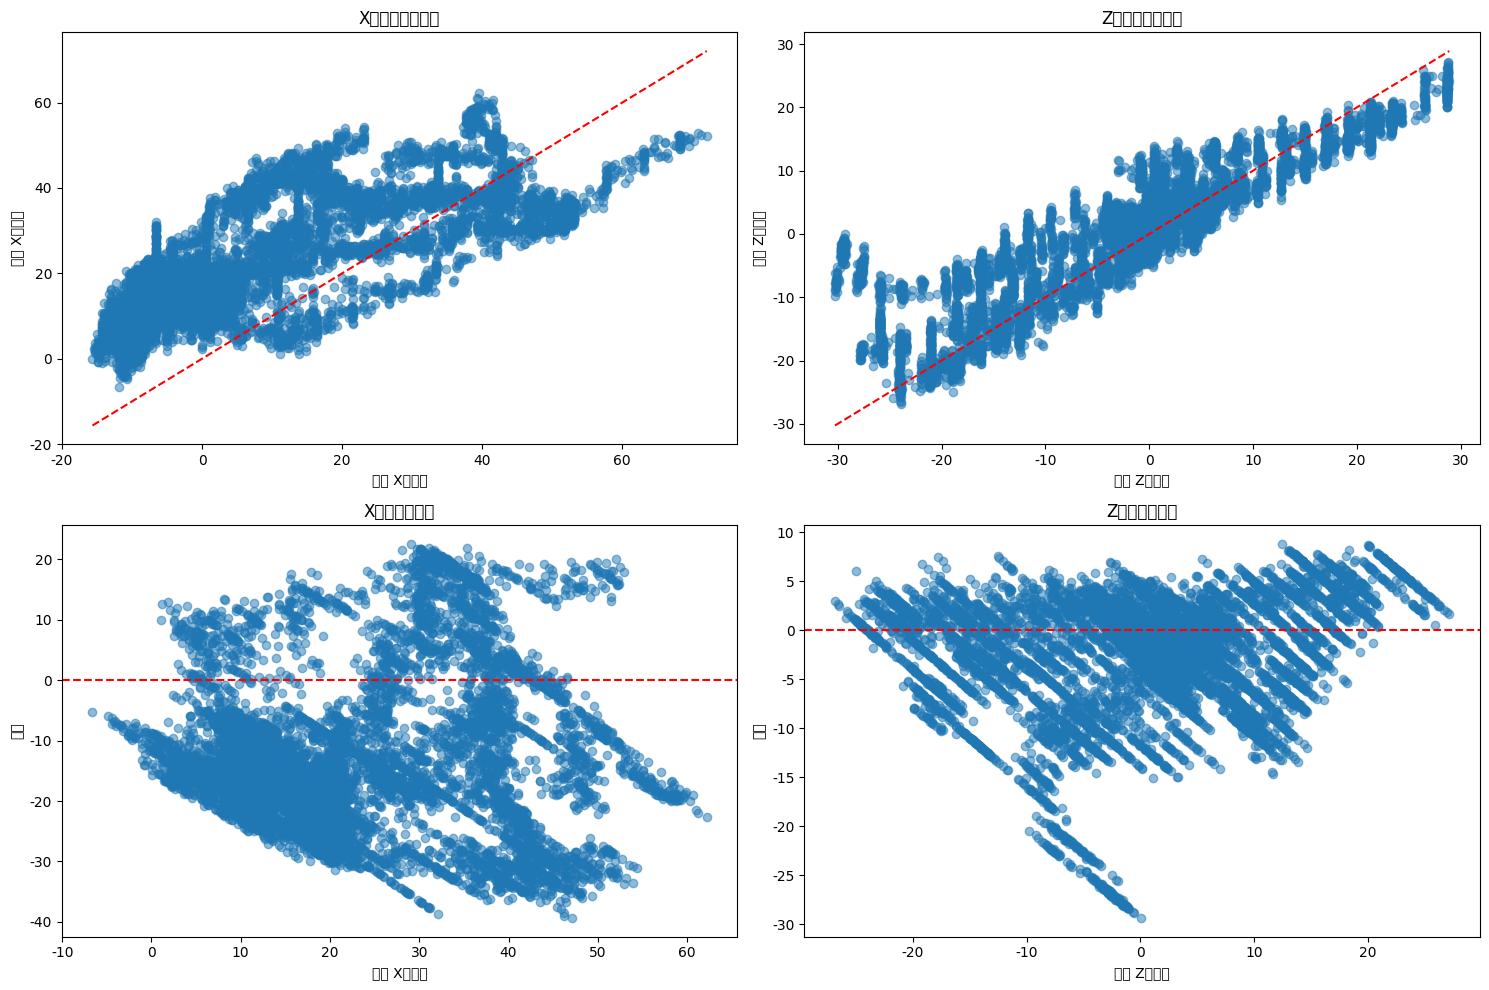


▶️ 模型: random_forest

=== 準備特徵資料 ===
輸入特徵數量: 25
時間特徵 (1): ['Time']
位置溫度特徵 (21): ['PT01', 'PT02', 'PT03', 'PT04', 'PT05', 'PT06', 'PT07', 'PT08', 'PT09', 'PT10', 'PT11', 'PT12', 'PT13', 'TC01', 'TC02', 'TC03', 'TC04', 'TC05', 'TC06', 'TC07', 'TC08']
馬達溫度特徵 (3): ['Spindle Motor', 'X Motor', 'Z Motor']

=== 處理缺失資料 ===
各欄位缺失值數量:
Series([], dtype: int64)
處理後剩餘缺失值數量: 0

=== 訓練模型 (random_forest) ===
訓練 X軸變位預測模型...
訓練 Z軸變位預測模型...
訓練 Z軸變位預測模型...


findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

模型訓練完成！

=== 模型評估 ===
整體 X軸變位 RMSE: 23.164155
整體 Z軸變位 RMSE: 10.515818
整體平均 RMSE: 16.839987
X軸變位 R²: -0.470204
Z軸變位 R²: 0.335262

=== 分區RMSE分析 ===

1. 按變位大小分區:
  X軸 P0-P25: RMSE=17.9703, 樣本數=2284
  X軸 P25-P50: RMSE=18.5377, 樣本數=2358
  X軸 P50-P75: RMSE=29.4636, 樣本數=2315
  X軸 P75-P100: RMSE=24.7379, 樣本數=2327
  Z軸 P0-P25: RMSE=17.4898, 樣本數=2309
  Z軸 P25-P50: RMSE=4.9981, 樣本數=2319
  Z軸 P50-P75: RMSE=5.6019, 樣本數=2334
  Z軸 P75-P100: RMSE=9.0258, 樣本數=2322

2. 按主軸馬達溫度分區:
  X軸 低溫區間: RMSE=21.5505, 樣本數=3013
  X軸 中溫區間: RMSE=28.6762, 樣本數=3048
  X軸 高溫區間: RMSE=18.2702, 樣本數=3223
  Z軸 低溫區間: RMSE=9.1897, 樣本數=3013
  Z軸 中溫區間: RMSE=13.1247, 樣本數=3048
  Z軸 高溫區間: RMSE=8.7570, 樣本數=3223

3. 按時間分區:
  X軸 初期: RMSE=11.3641, 樣本數=2321
  X軸 前期: RMSE=15.6485, 樣本數=2321
  X軸 中期: RMSE=31.2981, 樣本數=2321
  X軸 後期: RMSE=28.1554, 樣本數=2321
  Z軸 初期: RMSE=3.5731, 樣本數=2321
  Z軸 前期: RMSE=9.9333, 樣本數=2321
  Z軸 中期: RMSE=11.5609, 樣本數=2321
  Z軸 後期: RMSE=14.0442, 樣本數=2321

4. 極端值分析:
  X軸極端情況 (誤差>P95): RMSE=59.6656, 最大誤差=67.8328, 樣本數=466


findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

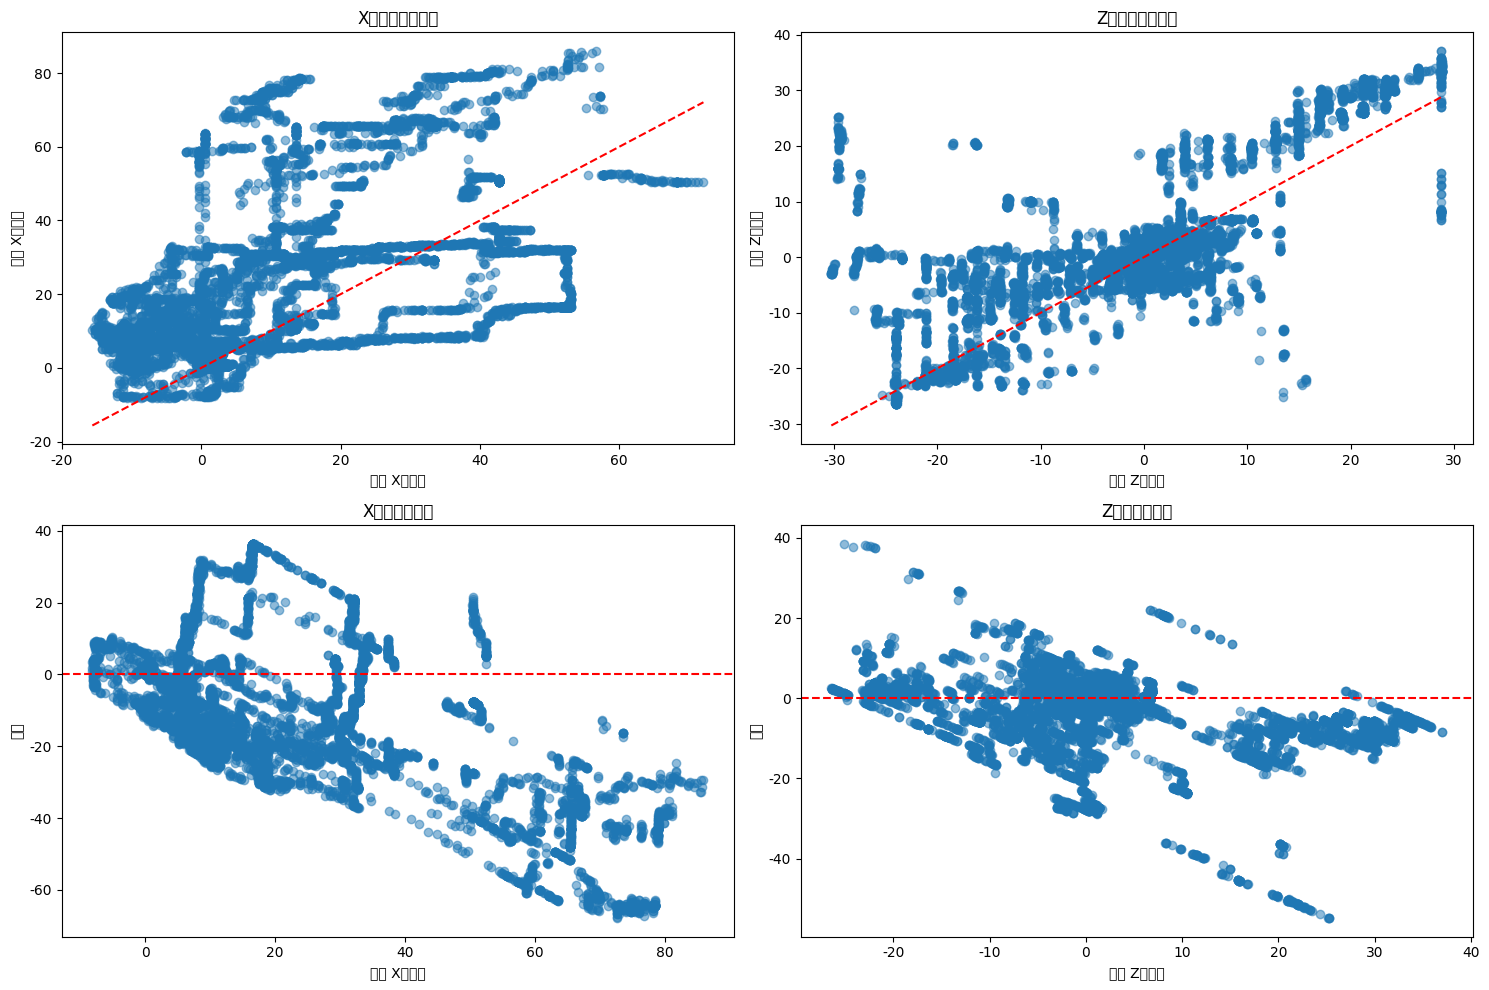


▶️ 模型: gradient_boosting

=== 準備特徵資料 ===
輸入特徵數量: 25
時間特徵 (1): ['Time']
位置溫度特徵 (21): ['PT01', 'PT02', 'PT03', 'PT04', 'PT05', 'PT06', 'PT07', 'PT08', 'PT09', 'PT10', 'PT11', 'PT12', 'PT13', 'TC01', 'TC02', 'TC03', 'TC04', 'TC05', 'TC06', 'TC07', 'TC08']
馬達溫度特徵 (3): ['Spindle Motor', 'X Motor', 'Z Motor']

=== 處理缺失資料 ===
各欄位缺失值數量:
Series([], dtype: int64)
處理後剩餘缺失值數量: 0

=== 訓練模型 (gradient_boosting) ===
訓練 X軸變位預測模型...
訓練 Z軸變位預測模型...
訓練 Z軸變位預測模型...


findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

模型訓練完成！

=== 模型評估 ===
整體 X軸變位 RMSE: 23.462257
整體 Z軸變位 RMSE: 9.657610
整體平均 RMSE: 16.559933
X軸變位 R²: -0.508288
Z軸變位 R²: 0.439335

=== 分區RMSE分析 ===

1. 按變位大小分區:
  X軸 P0-P25: RMSE=20.0357, 樣本數=2284
  X軸 P25-P50: RMSE=19.0992, 樣本數=2358
  X軸 P50-P75: RMSE=30.4685, 樣本數=2315
  X軸 P75-P100: RMSE=22.5619, 樣本數=2327
  Z軸 P0-P25: RMSE=15.8560, 樣本數=2309
  Z軸 P25-P50: RMSE=4.5049, 樣本數=2319
  Z軸 P50-P75: RMSE=3.3335, 樣本數=2334
  Z軸 P75-P100: RMSE=9.5642, 樣本數=2322

2. 按主軸馬達溫度分區:
  X軸 低溫區間: RMSE=22.2280, 樣本數=3013
  X軸 中溫區間: RMSE=29.1522, 樣本數=3048
  X軸 高溫區間: RMSE=17.8908, 樣本數=3223
  Z軸 低溫區間: RMSE=9.8172, 樣本數=3013
  Z軸 中溫區間: RMSE=11.1142, 樣本數=3048
  Z軸 高溫區間: RMSE=7.8581, 樣本數=3223

3. 按時間分區:
  X軸 初期: RMSE=11.6404, 樣本數=2321
  X軸 前期: RMSE=17.3709, 樣本數=2321
  X軸 中期: RMSE=29.4499, 樣本數=2321
  X軸 後期: RMSE=29.9561, 樣本數=2321
  Z軸 初期: RMSE=3.6954, 樣本數=2321
  Z軸 前期: RMSE=9.4856, 樣本數=2321
  Z軸 中期: RMSE=11.7402, 樣本數=2321
  Z軸 後期: RMSE=11.4723, 樣本數=2321

4. 極端值分析:
  X軸極端情況 (誤差>P95): RMSE=60.0650, 最大誤差=72.3351, 樣本數=465
 

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

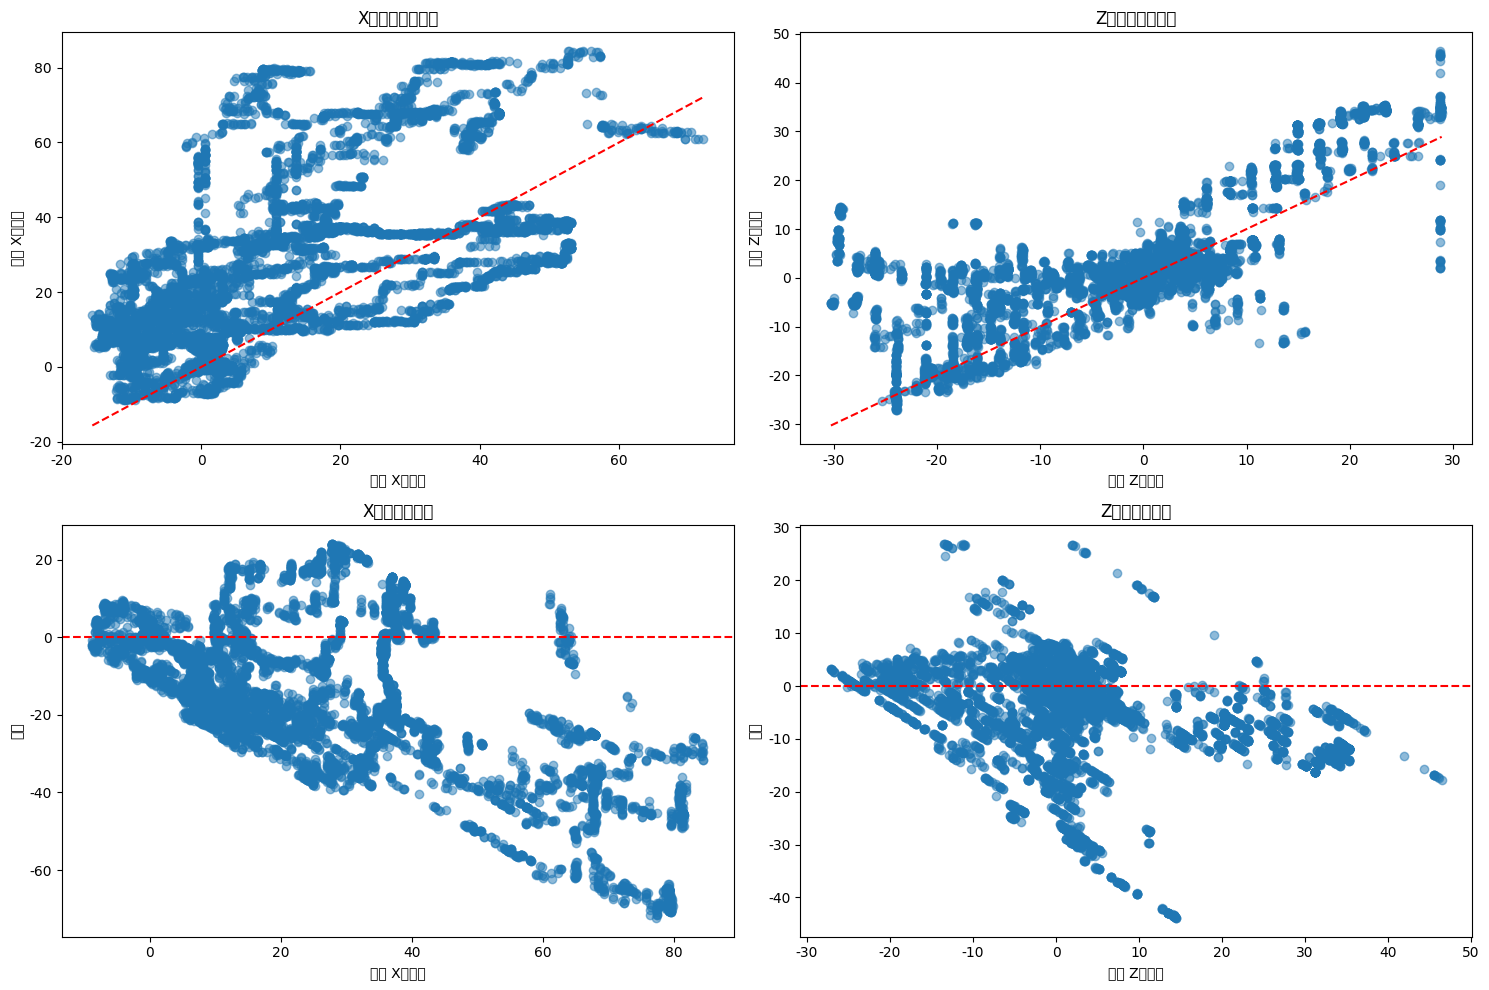

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 


🔬 策略: environment_split  (train=29, test=14)

▶️ 模型: linear

=== 準備特徵資料 ===
輸入特徵數量: 25
時間特徵 (1): ['Time']
位置溫度特徵 (21): ['PT01', 'PT02', 'PT03', 'PT04', 'PT05', 'PT06', 'PT07', 'PT08', 'PT09', 'PT10', 'PT11', 'PT12', 'PT13', 'TC01', 'TC02', 'TC03', 'TC04', 'TC05', 'TC06', 'TC07', 'TC08']
馬達溫度特徵 (3): ['Spindle Motor', 'X Motor', 'Z Motor']

=== 處理缺失資料 ===
各欄位缺失值數量:
Series([], dtype: int64)
處理後剩餘缺失值數量: 0

=== 訓練模型 (linear) ===
訓練 X軸變位預測模型...
訓練 Z軸變位預測模型...
模型訓練完成！

=== 模型評估 ===
整體 X軸變位 RMSE: 21.673819
整體 Z軸變位 RMSE: 5.472492
整體平均 RMSE: 13.573155
X軸變位 R²: -0.229246
Z軸變位 R²: 0.857165

=== 分區RMSE分析 ===

1. 按變位大小分區:
  X軸 P0-P25: RMSE=11.9590, 樣本數=2840
  X軸 P25-P50: RMSE=14.2834, 樣本數=2927
  X軸 P50-P75: RMSE=20.3527, 樣本數=2860
  X軸 P75-P100: RMSE=33.2649, 樣本數=2928
  Z軸 P0-P25: RMSE=7.2317, 樣本數=2886
  Z軸 P25-P50: RMSE=4.2933, 樣本數=2869
  Z軸 P50-P75: RMSE=3.2324, 樣本數=2905
  Z軸 P75-P100: RMSE=6.2168, 樣本數=2895

2. 按主軸馬達溫度分區:
  X軸 低溫區間: RMSE=9.1770, 樣本數=3445
  X軸 中溫區間: RMSE=26.1077, 樣本數=3458
  X軸 高溫區間

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

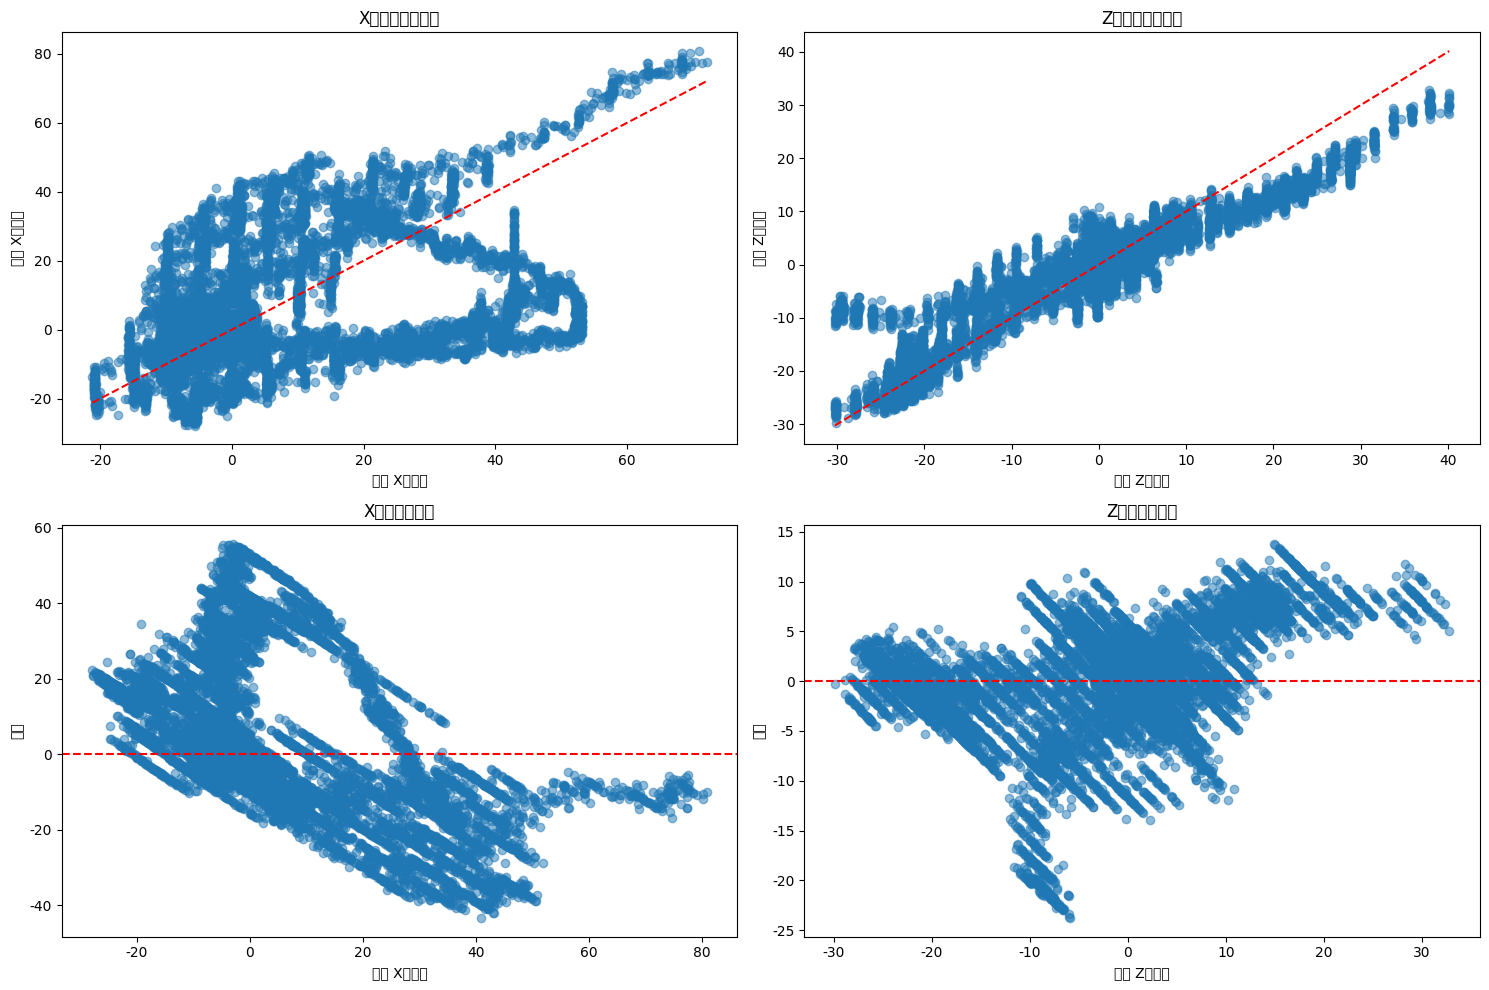


▶️ 模型: random_forest

=== 準備特徵資料 ===
輸入特徵數量: 25
時間特徵 (1): ['Time']
位置溫度特徵 (21): ['PT01', 'PT02', 'PT03', 'PT04', 'PT05', 'PT06', 'PT07', 'PT08', 'PT09', 'PT10', 'PT11', 'PT12', 'PT13', 'TC01', 'TC02', 'TC03', 'TC04', 'TC05', 'TC06', 'TC07', 'TC08']
馬達溫度特徵 (3): ['Spindle Motor', 'X Motor', 'Z Motor']

=== 處理缺失資料 ===
各欄位缺失值數量:
Series([], dtype: int64)
處理後剩餘缺失值數量: 0

=== 訓練模型 (random_forest) ===
訓練 X軸變位預測模型...
訓練 Z軸變位預測模型...
訓練 Z軸變位預測模型...


findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

模型訓練完成！

=== 模型評估 ===
整體 X軸變位 RMSE: 17.925377
整體 Z軸變位 RMSE: 11.582923
整體平均 RMSE: 14.754150
X軸變位 R²: 0.159177
Z軸變位 R²: 0.360115

=== 分區RMSE分析 ===

1. 按變位大小分區:
  X軸 P0-P25: RMSE=11.4016, 樣本數=2840
  X軸 P25-P50: RMSE=14.1107, 樣本數=2927
  X軸 P50-P75: RMSE=17.1598, 樣本數=2860
  X軸 P75-P100: RMSE=25.5987, 樣本數=2928
  Z軸 P0-P25: RMSE=13.2182, 樣本數=2886
  Z軸 P25-P50: RMSE=7.0438, 樣本數=2869
  Z軸 P50-P75: RMSE=8.1475, 樣本數=2905
  Z軸 P75-P100: RMSE=15.6697, 樣本數=2895

2. 按主軸馬達溫度分區:
  X軸 低溫區間: RMSE=11.9543, 樣本數=3445
  X軸 中溫區間: RMSE=26.5792, 樣本數=3458
  X軸 高溫區間: RMSE=12.9289, 樣本數=4652
  Z軸 低溫區間: RMSE=5.6740, 樣本數=3445
  Z軸 中溫區間: RMSE=17.3607, 樣本數=3458
  Z軸 高溫區間: RMSE=9.2396, 樣本數=4652

3. 按時間分區:
  X軸 初期: RMSE=3.7884, 樣本數=2889
  X軸 前期: RMSE=15.3293, 樣本數=2888
  X軸 中期: RMSE=26.2007, 樣本數=2889
  X軸 後期: RMSE=18.6931, 樣本數=2889
  Z軸 初期: RMSE=4.0918, 樣本數=2889
  Z軸 前期: RMSE=7.8954, 樣本數=2888
  Z軸 中期: RMSE=13.5828, 樣本數=2889
  Z軸 後期: RMSE=16.5245, 樣本數=2889

4. 極端值分析:
  X軸極端情況 (誤差>P95): RMSE=49.8697, 最大誤差=65.7112, 樣本數=578
 

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

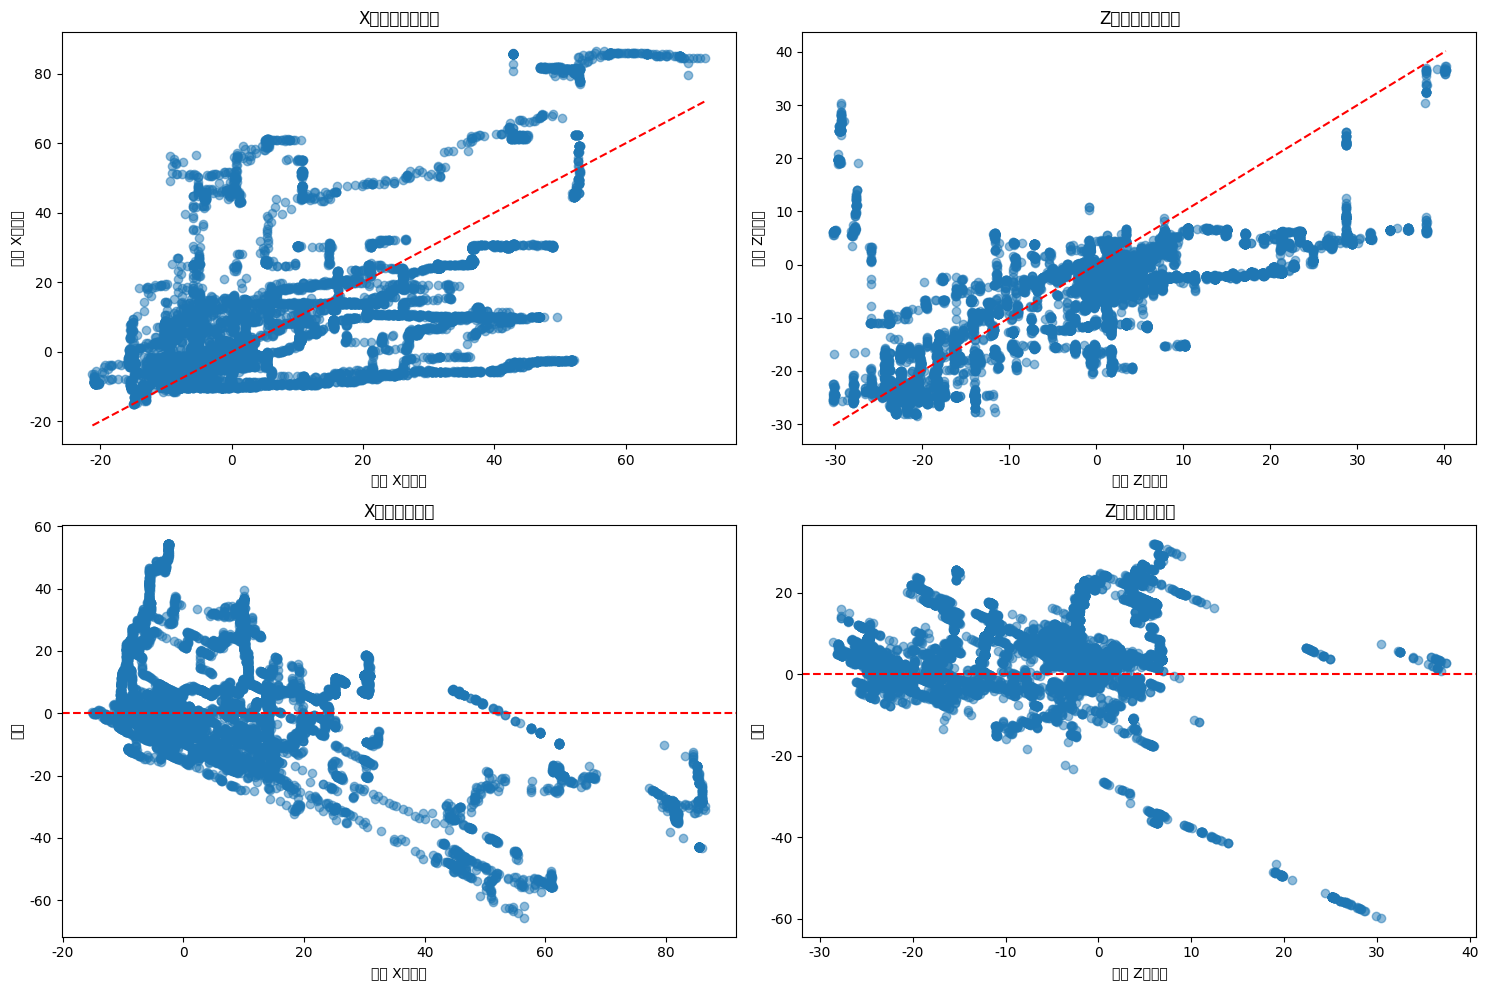


▶️ 模型: gradient_boosting

=== 準備特徵資料 ===
輸入特徵數量: 25
時間特徵 (1): ['Time']
位置溫度特徵 (21): ['PT01', 'PT02', 'PT03', 'PT04', 'PT05', 'PT06', 'PT07', 'PT08', 'PT09', 'PT10', 'PT11', 'PT12', 'PT13', 'TC01', 'TC02', 'TC03', 'TC04', 'TC05', 'TC06', 'TC07', 'TC08']
馬達溫度特徵 (3): ['Spindle Motor', 'X Motor', 'Z Motor']

=== 處理缺失資料 ===
各欄位缺失值數量:
Series([], dtype: int64)
處理後剩餘缺失值數量: 0

=== 訓練模型 (gradient_boosting) ===
訓練 X軸變位預測模型...
訓練 Z軸變位預測模型...
訓練 Z軸變位預測模型...


findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

模型訓練完成！

=== 模型評估 ===
整體 X軸變位 RMSE: 16.004150
整體 Z軸變位 RMSE: 10.033530
整體平均 RMSE: 13.018840
X軸變位 R²: 0.329755
Z軸變位 R²: 0.519854

=== 分區RMSE分析 ===

1. 按變位大小分區:
  X軸 P0-P25: RMSE=10.7412, 樣本數=2840
  X軸 P25-P50: RMSE=12.6484, 樣本數=2927
  X軸 P50-P75: RMSE=13.8280, 樣本數=2860
  X軸 P75-P100: RMSE=23.4988, 樣本數=2928
  Z軸 P0-P25: RMSE=9.9113, 樣本數=2886
  Z軸 P25-P50: RMSE=5.1499, 樣本數=2869
  Z軸 P50-P75: RMSE=7.6697, 樣本數=2905
  Z軸 P75-P100: RMSE=14.7844, 樣本數=2895

2. 按主軸馬達溫度分區:
  X軸 低溫區間: RMSE=12.1651, 樣本數=3445
  X軸 中溫區間: RMSE=22.7659, 樣本數=3458
  X軸 高溫區間: RMSE=11.8891, 樣本數=4652
  Z軸 低溫區間: RMSE=5.1624, 樣本數=3445
  Z軸 中溫區間: RMSE=14.8506, 樣本數=3458
  Z軸 高溫區間: RMSE=8.1478, 樣本數=4652

3. 按時間分區:
  X軸 初期: RMSE=3.6808, 樣本數=2889
  X軸 前期: RMSE=14.8693, 樣本數=2888
  X軸 中期: RMSE=22.9205, 樣本數=2889
  X軸 後期: RMSE=16.2643, 樣本數=2889
  Z軸 初期: RMSE=3.9203, 樣本數=2889
  Z軸 前期: RMSE=7.9045, 樣本數=2888
  Z軸 中期: RMSE=12.3697, 樣本數=2889
  Z軸 後期: RMSE=13.1078, 樣本數=2889

4. 極端值分析:
  X軸極端情況 (誤差>P95): RMSE=43.8739, 最大誤差=52.6648, 樣本數=581
  

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

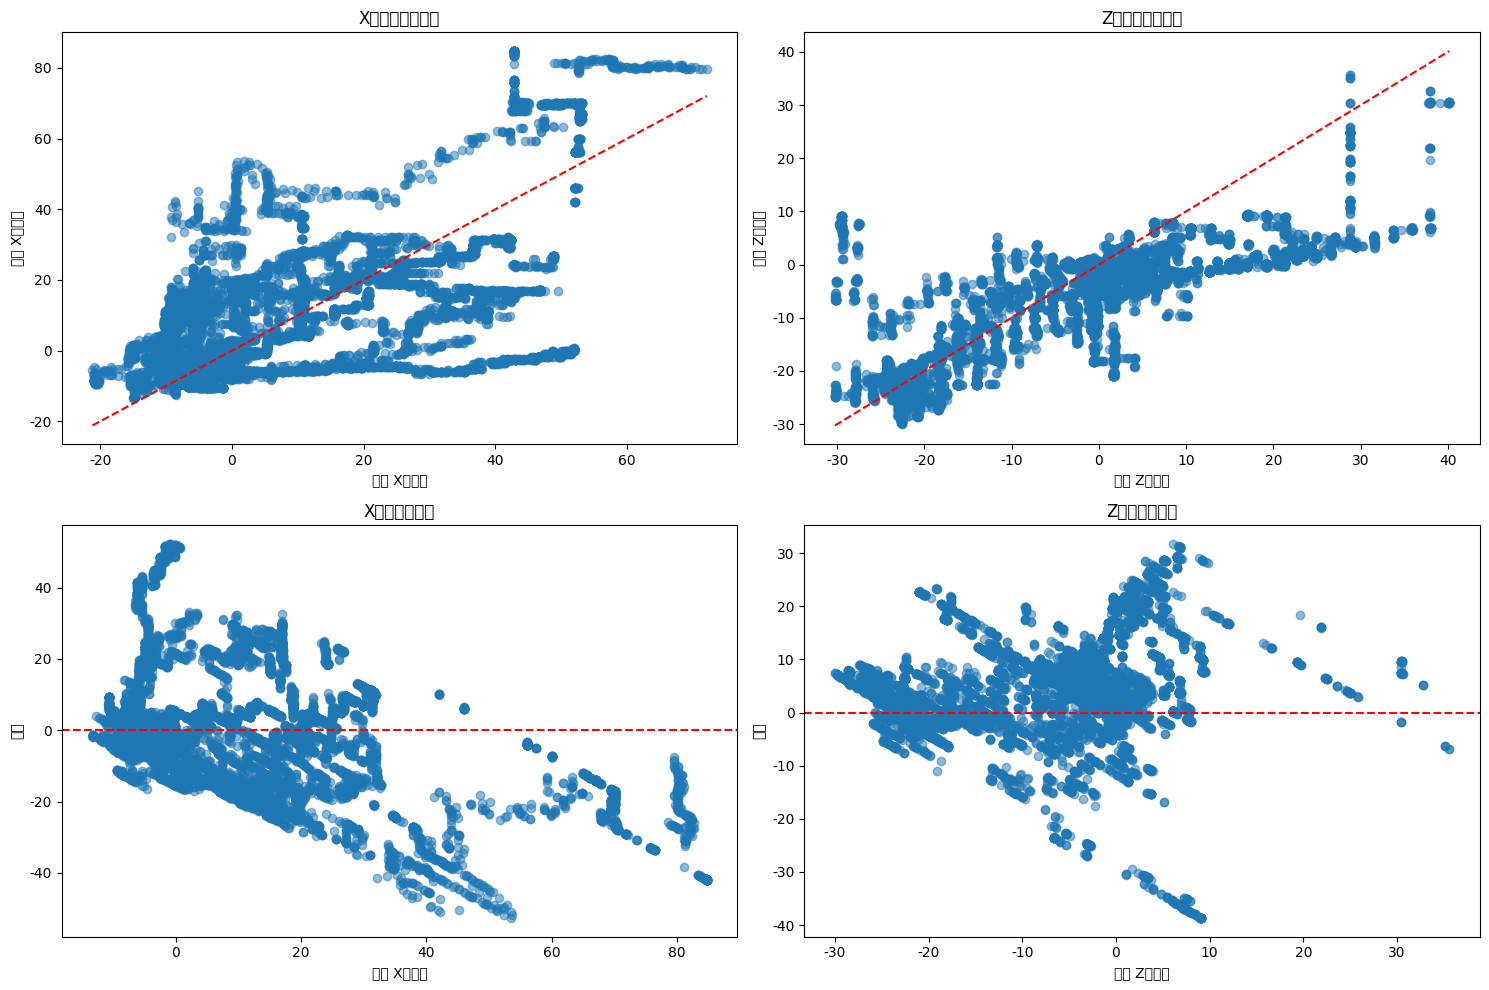

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 


🔬 策略: few_shot_split  (train=17, test=26)

▶️ 模型: linear

=== 準備特徵資料 ===
輸入特徵數量: 25
時間特徵 (1): ['Time']
位置溫度特徵 (21): ['PT01', 'PT02', 'PT03', 'PT04', 'PT05', 'PT06', 'PT07', 'PT08', 'PT09', 'PT10', 'PT11', 'PT12', 'PT13', 'TC01', 'TC02', 'TC03', 'TC04', 'TC05', 'TC06', 'TC07', 'TC08']
馬達溫度特徵 (3): ['Spindle Motor', 'X Motor', 'Z Motor']

=== 處理缺失資料 ===
各欄位缺失值數量:
Series([], dtype: int64)
處理後剩餘缺失值數量: 0

=== 訓練模型 (linear) ===
訓練 X軸變位預測模型...
訓練 Z軸變位預測模型...
模型訓練完成！

=== 模型評估 ===
整體 X軸變位 RMSE: 12.958115
整體 Z軸變位 RMSE: 6.850301
整體平均 RMSE: 9.904208
X軸變位 R²: 0.439249
Z軸變位 R²: 0.732425

=== 分區RMSE分析 ===

1. 按變位大小分區:
  X軸 P0-P25: RMSE=9.2557, 樣本數=4153
  X軸 P25-P50: RMSE=9.9546, 樣本數=4143
  X軸 P50-P75: RMSE=16.7048, 樣本數=4189
  X軸 P75-P100: RMSE=14.3717, 樣本數=4171
  Z軸 P0-P25: RMSE=6.5102, 樣本數=4162
  Z軸 P25-P50: RMSE=5.4210, 樣本數=4033
  Z軸 P50-P75: RMSE=3.7070, 樣本數=4261
  Z軸 P75-P100: RMSE=10.0965, 樣本數=4200

2. 按主軸馬達溫度分區:
  X軸 低溫區間: RMSE=12.2678, 樣本數=5379
  X軸 中溫區間: RMSE=11.5363, 樣本數=5016
  X軸 高溫區間: RMS

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

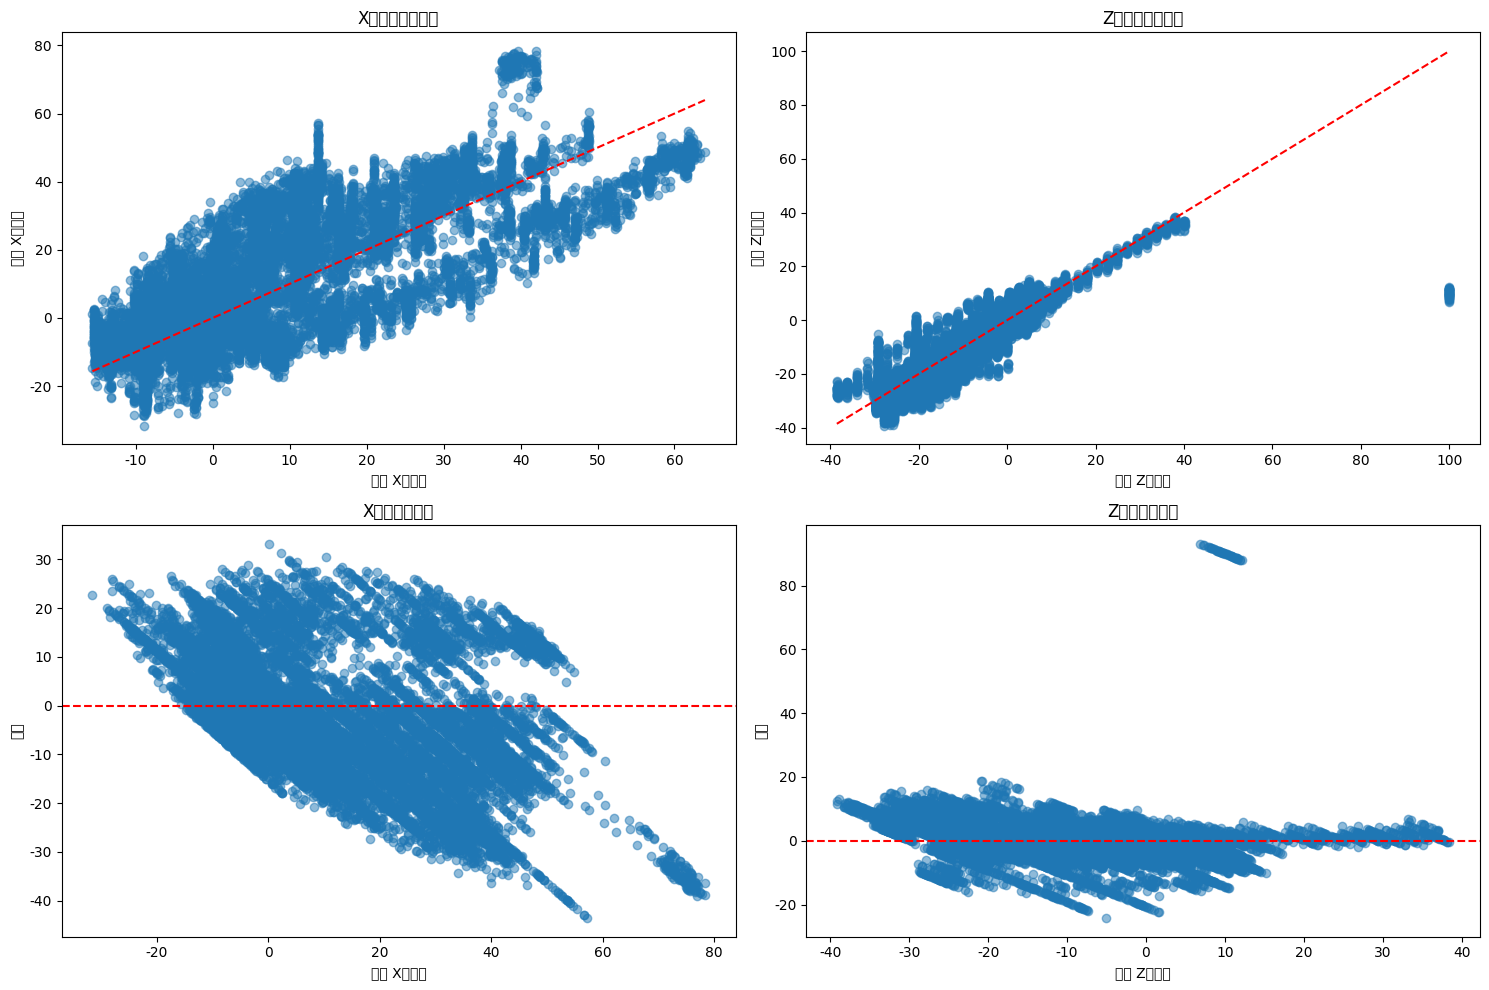


▶️ 模型: random_forest

=== 準備特徵資料 ===
輸入特徵數量: 25
時間特徵 (1): ['Time']
位置溫度特徵 (21): ['PT01', 'PT02', 'PT03', 'PT04', 'PT05', 'PT06', 'PT07', 'PT08', 'PT09', 'PT10', 'PT11', 'PT12', 'PT13', 'TC01', 'TC02', 'TC03', 'TC04', 'TC05', 'TC06', 'TC07', 'TC08']
馬達溫度特徵 (3): ['Spindle Motor', 'X Motor', 'Z Motor']

=== 處理缺失資料 ===
各欄位缺失值數量:
Series([], dtype: int64)
處理後剩餘缺失值數量: 0

=== 訓練模型 (random_forest) ===
訓練 X軸變位預測模型...
訓練 Z軸變位預測模型...
訓練 Z軸變位預測模型...


findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

模型訓練完成！

=== 模型評估 ===
整體 X軸變位 RMSE: 18.086846
整體 Z軸變位 RMSE: 16.828080
整體平均 RMSE: 17.457463
X軸變位 R²: -0.092477
Z軸變位 R²: -0.614712

=== 分區RMSE分析 ===

1. 按變位大小分區:
  X軸 P0-P25: RMSE=7.8540, 樣本數=4153
  X軸 P25-P50: RMSE=13.3980, 樣本數=4143
  X軸 P50-P75: RMSE=21.5990, 樣本數=4189
  X軸 P75-P100: RMSE=24.4558, 樣本數=4171
  Z軸 P0-P25: RMSE=16.1661, 樣本數=4162
  Z軸 P25-P50: RMSE=14.0961, 樣本數=4033
  Z軸 P50-P75: RMSE=12.4557, 樣本數=4261
  Z軸 P75-P100: RMSE=22.7124, 樣本數=4200

2. 按主軸馬達溫度分區:
  X軸 低溫區間: RMSE=17.1590, 樣本數=5379
  X軸 中溫區間: RMSE=17.2846, 樣本數=5016
  X軸 高溫區間: RMSE=19.4413, 樣本數=6261
  Z軸 低溫區間: RMSE=9.9627, 樣本數=5379
  Z軸 中溫區間: RMSE=22.6017, 樣本數=5016
  Z軸 高溫區間: RMSE=16.0878, 樣本數=6261

3. 按時間分區:
  X軸 初期: RMSE=5.7889, 樣本數=4164
  X軸 前期: RMSE=14.3281, 樣本數=4164
  X軸 中期: RMSE=22.0200, 樣本數=4163
  X軸 後期: RMSE=24.1832, 樣本數=4165
  Z軸 初期: RMSE=7.2353, 樣本數=4164
  Z軸 前期: RMSE=14.7100, 樣本數=4164
  Z軸 中期: RMSE=17.6467, 樣本數=4163
  Z軸 後期: RMSE=23.5062, 樣本數=4165

4. 極端值分析:
  X軸極端情況 (誤差>P95): RMSE=50.6935, 最大誤差=70.8959, 樣本數=

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

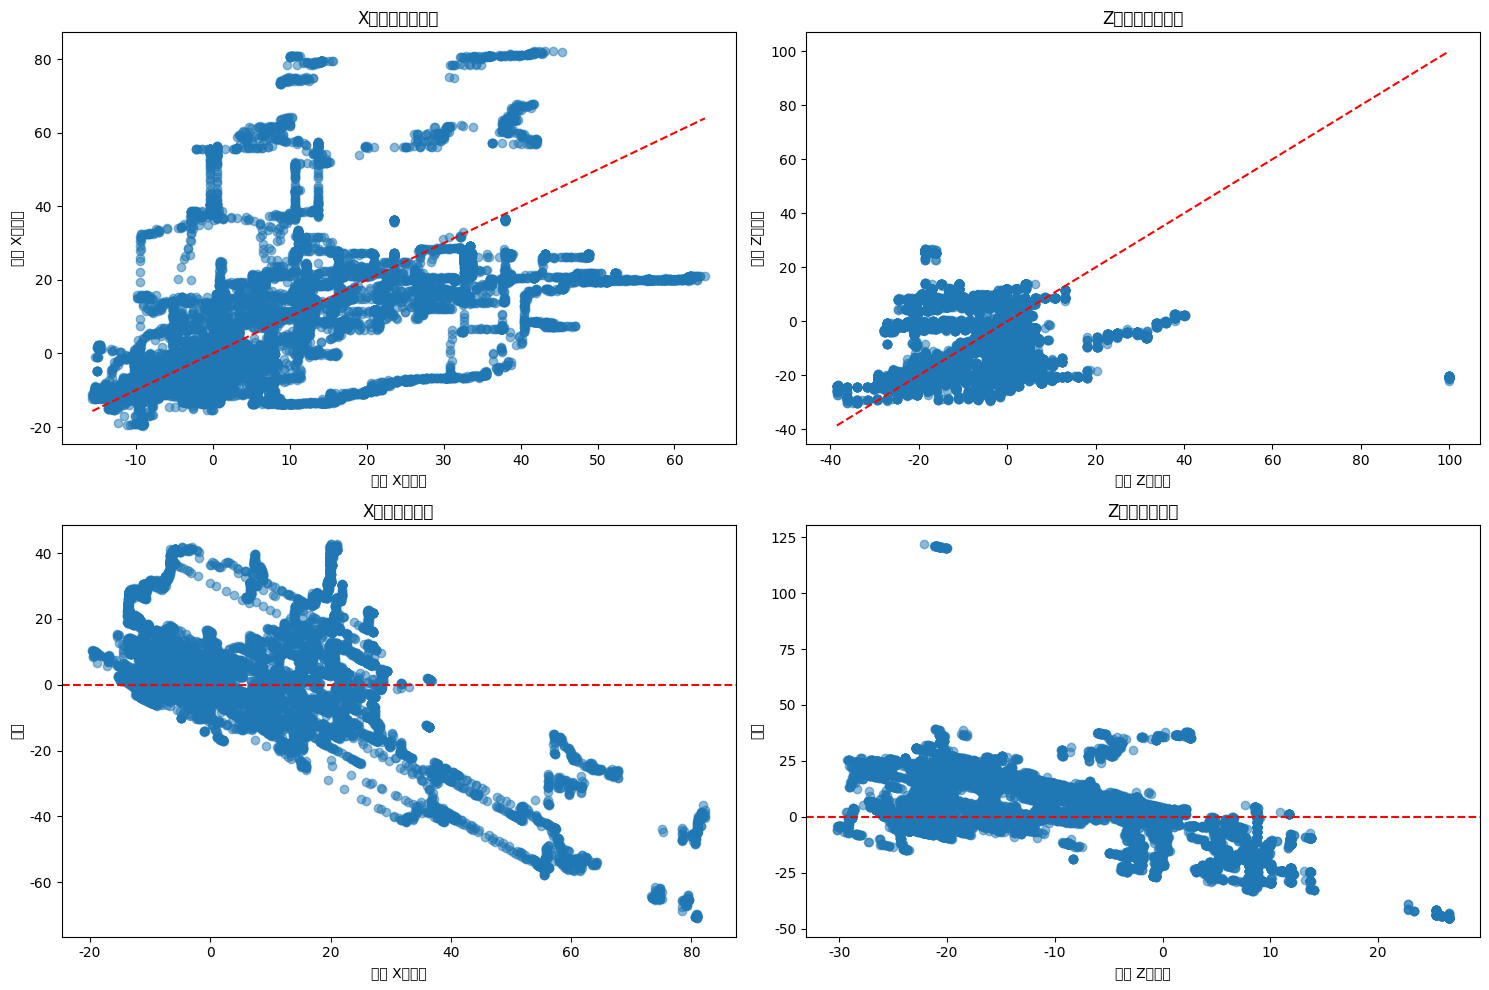


▶️ 模型: gradient_boosting

=== 準備特徵資料 ===
輸入特徵數量: 25
時間特徵 (1): ['Time']
位置溫度特徵 (21): ['PT01', 'PT02', 'PT03', 'PT04', 'PT05', 'PT06', 'PT07', 'PT08', 'PT09', 'PT10', 'PT11', 'PT12', 'PT13', 'TC01', 'TC02', 'TC03', 'TC04', 'TC05', 'TC06', 'TC07', 'TC08']
馬達溫度特徵 (3): ['Spindle Motor', 'X Motor', 'Z Motor']

=== 處理缺失資料 ===
各欄位缺失值數量:
Series([], dtype: int64)
處理後剩餘缺失值數量: 0

=== 訓練模型 (gradient_boosting) ===
訓練 X軸變位預測模型...
訓練 Z軸變位預測模型...
訓練 Z軸變位預測模型...


findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

模型訓練完成！

=== 模型評估 ===
整體 X軸變位 RMSE: 17.751246
整體 Z軸變位 RMSE: 16.213146
整體平均 RMSE: 16.982196
X軸變位 R²: -0.052311
Z軸變位 R²: -0.498858

=== 分區RMSE分析 ===

1. 按變位大小分區:
  X軸 P0-P25: RMSE=6.5289, 樣本數=4153
  X軸 P25-P50: RMSE=13.0117, 樣本數=4143
  X軸 P50-P75: RMSE=21.4680, 樣本數=4189
  X軸 P75-P100: RMSE=24.1834, 樣本數=4171
  Z軸 P0-P25: RMSE=14.9476, 樣本數=4162
  Z軸 P25-P50: RMSE=13.3778, 樣本數=4033
  Z軸 P50-P75: RMSE=12.4250, 樣本數=4261
  Z軸 P75-P100: RMSE=22.1939, 樣本數=4200

2. 按主軸馬達溫度分區:
  X軸 低溫區間: RMSE=17.0610, 樣本數=5379
  X軸 中溫區間: RMSE=16.6284, 樣本數=5016
  X軸 高溫區間: RMSE=19.1488, 樣本數=6261
  Z軸 低溫區間: RMSE=9.9181, 樣本數=5379
  Z軸 中溫區間: RMSE=22.0041, 樣本數=5016
  Z軸 高溫區間: RMSE=15.0627, 樣本數=6261

3. 按時間分區:
  X軸 初期: RMSE=5.8150, 樣本數=4164
  X軸 前期: RMSE=12.9459, 樣本數=4164
  X軸 中期: RMSE=21.5314, 樣本數=4163
  X軸 後期: RMSE=24.4004, 樣本數=4165
  Z軸 初期: RMSE=8.1945, 樣本數=4164
  Z軸 前期: RMSE=14.1844, 樣本數=4164
  Z軸 中期: RMSE=16.4833, 樣本數=4163
  Z軸 後期: RMSE=22.6133, 樣本數=4165

4. 極端值分析:
  X軸極端情況 (誤差>P95): RMSE=51.4103, 最大誤差=69.2028, 樣本數=

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

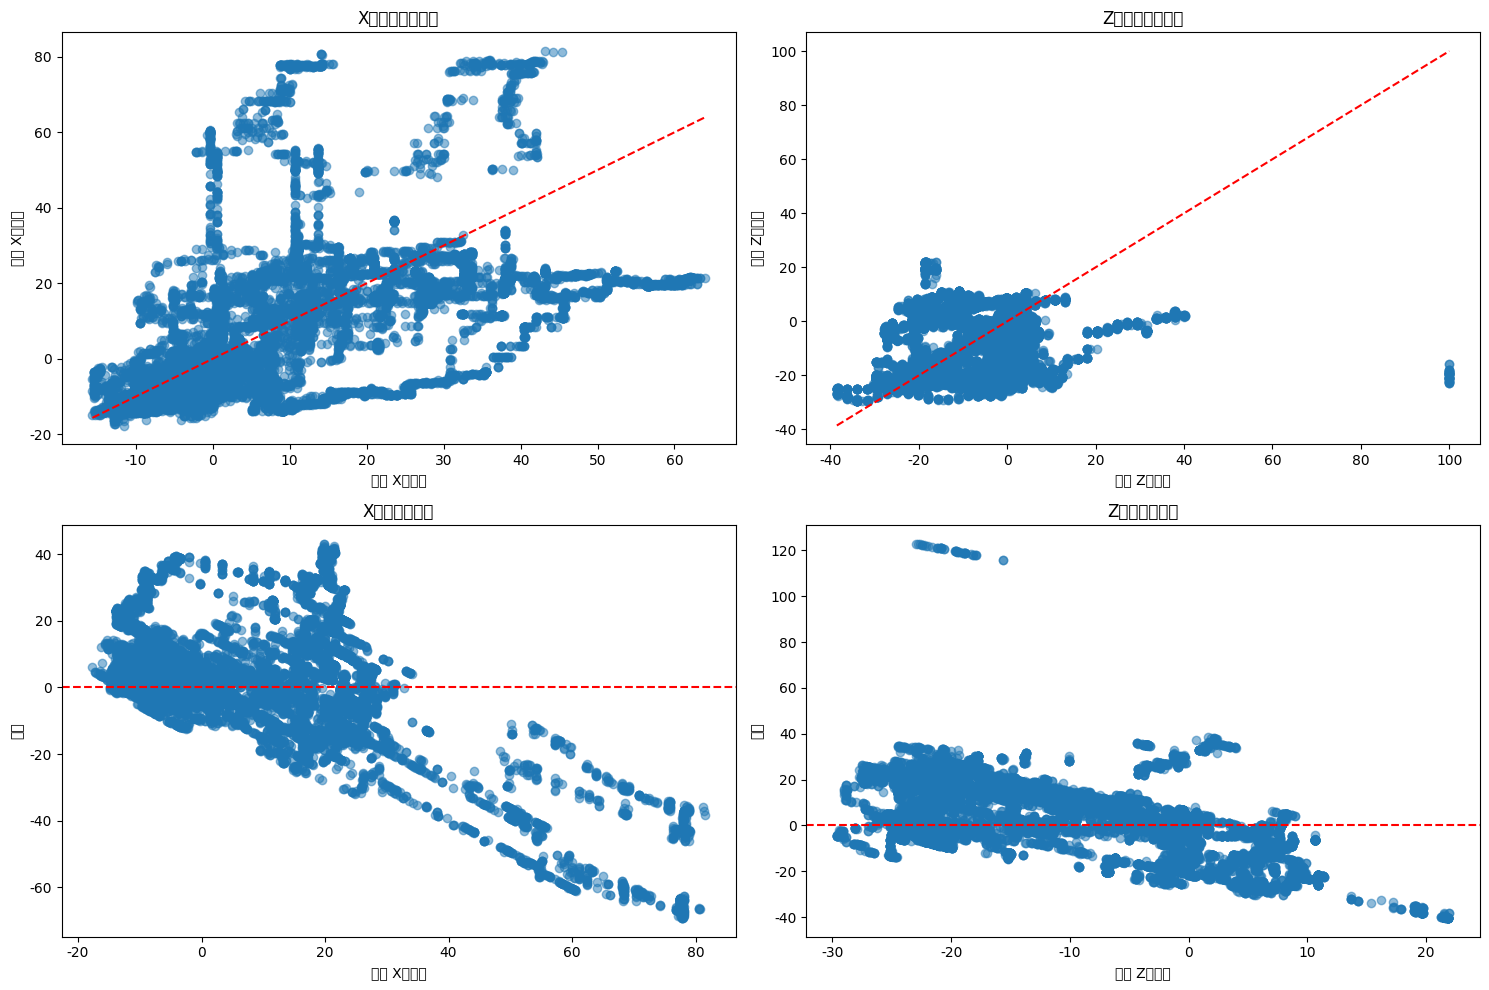

strategy              model     rmse_X     rmse_Z   avg_rmse
6     few_shot_split             linear  12.958115   6.850301   9.904208
0         time_split             linear  17.867090   6.209341  12.038216
5  environment_split  gradient_boosting  16.004150  10.033530  13.018840
3  environment_split             linear  21.673819   5.472492  13.573155
4  environment_split      random_forest  17.925377  11.582923  14.754150
2         time_split  gradient_boosting  23.462257   9.657610  16.559933
1         time_split      random_forest  23.164155  10.515818  16.839987
8     few_shot_split  gradient_boosting  17.751246  16.213146  16.982196
7     few_shot_split      random_forest  18.086846  16.828080  17.457463

In [55]:
# === 執行三種策略 x 三種模型 ===
strategies = {
    'time_split': (time_train_df, time_test_df),
    'environment_split': (env_train_df, env_test_df),
    'few_shot_split': (few_train_df, few_test_df)
}
models = ['linear', 'random_forest', 'gradient_boosting']
results_records = []

for strat_name, (tr_df, te_df) in strategies.items():
    train_files = tr_df['file_path'].tolist()
    test_files = te_df['file_path'].tolist()
    print('\n' + '='*70)
    print(f'🔬 策略: {strat_name}  (train={len(train_files)}, test={len(test_files)})')
    for m in models:
        print(f"\n▶️ 模型: {m}")
        res = train_and_evaluate_with_custom_split(train_files, test_files, model_type=m)
        results_records.append({
            'strategy': strat_name,
            'model': m,
            'rmse_X': res['rmse_X'],
            'rmse_Z': res['rmse_Z'],
            'avg_rmse': res['avg_rmse']
        })

results_df = pd.DataFrame(results_records)
results_df.sort_values('avg_rmse')

In [56]:
# Summarize results: best per strategy and overall
import pandas as pd

# Ensure results_df exists
assert 'results_df' in globals(), 'results_df not found – run previous cells.'

# Sort by avg_rmse ascending
sorted_df = results_df.sort_values('avg_rmse')
print('All results (sorted by avg_rmse):')
print(sorted_df)

# Best model per strategy
best_per_strategy = results_df.loc[results_df.groupby('strategy')['avg_rmse'].idxmin()].reset_index(drop=True)
print('\nBest per strategy:')
print(best_per_strategy)

# Overall best
overall_best = sorted_df.iloc[0]
print('\nOverall best:')
print(overall_best)

# Save to CSV for persistence
summary_path = f"{EXPERIMENT_ROOT}/results_summary.csv"
results_df.to_csv(summary_path, index=False)
print(f"\nSaved full results to: {summary_path}")

best_per_strategy_path = f"{EXPERIMENT_ROOT}/best_per_strategy.csv"
best_per_strategy.to_csv(best_per_strategy_path, index=False)
print(f"Saved best per strategy to: {best_per_strategy_path}")

overall_best_path = f"{EXPERIMENT_ROOT}/overall_best.json"
overall_best.to_json(overall_best_path)
print(f"Saved overall best to: {overall_best_path}")

All results (sorted by avg_rmse):
            strategy              model     rmse_X     rmse_Z   avg_rmse
6     few_shot_split             linear  12.958115   6.850301   9.904208
0         time_split             linear  17.867090   6.209341  12.038216
5  environment_split  gradient_boosting  16.004150  10.033530  13.018840
3  environment_split             linear  21.673819   5.472492  13.573155
4  environment_split      random_forest  17.925377  11.582923  14.754150
2         time_split  gradient_boosting  23.462257   9.657610  16.559933
1         time_split      random_forest  23.164155  10.515818  16.839987
8     few_shot_split  gradient_boosting  17.751246  16.213146  16.982196
7     few_shot_split      random_forest  18.086846  16.828080  17.457463

Best per strategy:
            strategy              model     rmse_X     rmse_Z   avg_rmse
0  environment_split  gradient_boosting  16.004150  10.033530  13.018840
1     few_shot_split             linear  12.958115   6.850301   9.9042

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

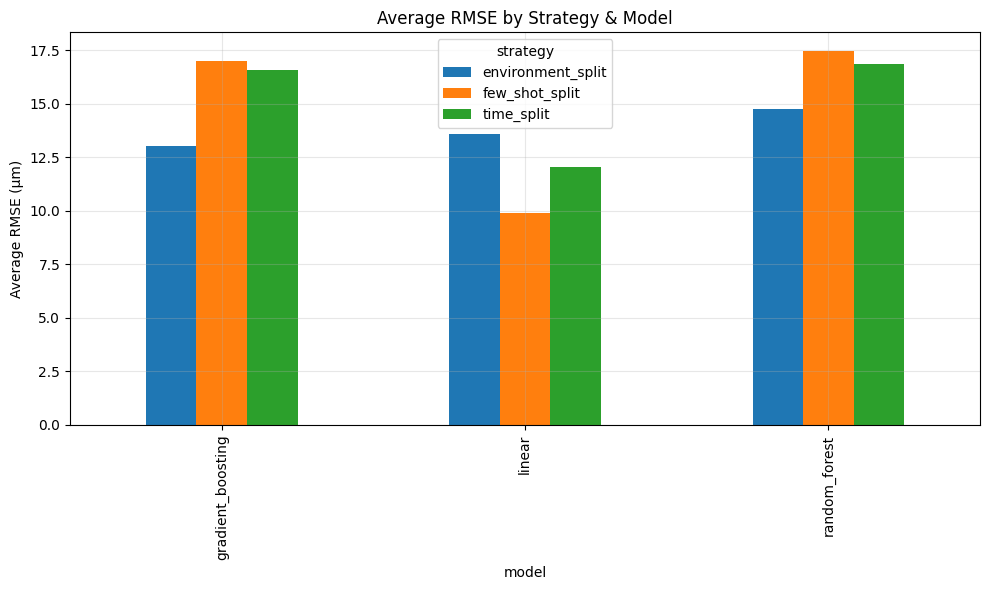

strategy           environment_split  few_shot_split  time_split
model                                                           
gradient_boosting          13.018840       16.982196   16.559933
linear                     13.573155        9.904208   12.038216
random_forest              14.754150       17.457463   16.839987

In [57]:
# === 視覺化：各策略 / 模型 平均RMSE 柱狀圖 ===
import matplotlib.pyplot as plt
pivot_df = results_df.pivot(index='model', columns='strategy', values='avg_rmse')
pivot_df.plot(kind='bar', figsize=(10,6))
plt.ylabel('Average RMSE (μm)')
plt.title('Average RMSE by Strategy & Model')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
pivot_df

## 為何現在 RMSE 比之前全樣本測試 (<7) 大？
下面新增一個診斷區：
1. 早期「全樣本測試 <7」很可能是【逐列隨機拆分 row-level shuffle】：同一檔案的時間序列被打散，鄰近點高度相關，模型容易「記住」模式；測試集含與訓練集幾乎相同分佈的相鄰片段 ⇒ 偏樂觀。
2. 目前三種策略用的是【檔案層級 file-level】切分：整個檔案完全屬於 train 或 test，時間/條件不再被打散，挑戰更接近真實部署 ⇒ RMSE 合理升高。
3. Few-Shot：每個 (控溫+溫度) 組合只拿 1 檔訓練，其餘全測試，屬於極低資料 + domain shift，RMSE 更高合理。
4. 截斷後資料可能集中在尚未熱穩定區段，變位曲線更非線性，線性或未調參模型表現下降。
5. 目前隨機森林 / GBDT 都是預設超參數，未調參 + 訓練樣本減少，性能未充分發揮。

接下來補兩個 baseline 以量化差距：
- Baseline A: 逐列隨機拆分 (row-level)（重現早期 <7 現象）
- Baseline B: 檔案隨機拆分 (file-level random)（與時間/環境/ few-shot 對照）

再計算其 RMSE，確認差異原因。

In [58]:
# === Baseline A: 逐列隨機拆分 vs Baseline B: 檔案隨機拆分 (file-level random) ===
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# 收集所有檔案資料 (沿用 earlier helper)
all_file_paths = all_files_df['file_path'].tolist()
all_rows = []
for fp in all_file_paths:
    try:
        df = pd.read_csv(fp)
        df['__source_file'] = os.path.basename(fp)
        all_rows.append(df)
    except Exception as e:
        print('讀取失敗', fp, e)
full_df = pd.concat(all_rows, ignore_index=True)

# 選取與主模型一致的特徵欄位 (可能缺失部分欄位需過濾)
base_predictor = ThermalDisplacementPredictor(data_path=BASE_DATA_DIR)
base_predictor.data = full_df.copy()
base_predictor.prepare_features()
base_predictor.handle_missing_data()
feature_cols = base_predictor.feature_columns

# Baseline A: 逐列隨機拆分 (row-level)
X_all = base_predictor.data[feature_cols]
y_all = base_predictor.data[base_predictor.target_columns]
X_tr_row, X_te_row, y_tr_row, y_te_row = train_test_split(X_all, y_all, test_size=0.23, random_state=42, shuffle=True)

row_model_X = LinearRegression(); row_model_Z = LinearRegression()
row_model_X.fit(X_tr_row, y_tr_row['Disp. X'])
row_model_Z.fit(X_tr_row, y_tr_row['Disp. Z'])
y_pred_row_X = row_model_X.predict(X_te_row)
y_pred_row_Z = row_model_Z.predict(X_te_row)
row_rmse_X = (mean_squared_error(y_te_row['Disp. X'], y_pred_row_X)**0.5)
row_rmse_Z = (mean_squared_error(y_te_row['Disp. Z'], y_pred_row_Z)**0.5)
row_avg = (row_rmse_X + row_rmse_Z)/2
print(f"Baseline A (Row-level random) RMSE_X={row_rmse_X:.4f}, RMSE_Z={row_rmse_Z:.4f}, AVG={row_avg:.4f}")

# Baseline B: 檔案隨機拆分 (file-level random)
file_df = all_files_df.sample(frac=1, random_state=42).reset_index(drop=True)
cut = int(len(file_df)*0.77)
file_train_paths = file_df.iloc[:cut]['file_path'].tolist()
file_test_paths = file_df.iloc[cut:]['file_path'].tolist()

train_rows = []
for fp in file_train_paths:
    df = pd.read_csv(fp); df['__source_file'] = os.path.basename(fp); train_rows.append(df)
train_concat = pd.concat(train_rows, ignore_index=True)

test_rows = []
for fp in file_test_paths:
    df = pd.read_csv(fp); df['__source_file'] = os.path.basename(fp); test_rows.append(df)
test_concat = pd.concat(test_rows, ignore_index=True)

# 將特徵對齊 (可能部分欄位缺失，重新補處理)
train_concat = train_concat.copy(); test_concat = test_concat.copy()
for col in feature_cols + base_predictor.target_columns:
    if col in train_concat.columns and train_concat[col].isnull().any():
        train_concat[col] = train_concat[col].interpolate().bfill().ffill()
    if col in test_concat.columns and test_concat[col].isnull().any():
        test_concat[col] = test_concat[col].interpolate().bfill().ffill()

X_tr_file = train_concat[feature_cols]
y_tr_file = train_concat[base_predictor.target_columns]
X_te_file = test_concat[feature_cols]
y_te_file = test_concat[base_predictor.target_columns]

file_model_X = LinearRegression(); file_model_Z = LinearRegression()
file_model_X.fit(X_tr_file, y_tr_file['Disp. X'])
file_model_Z.fit(X_tr_file, y_tr_file['Disp. Z'])
y_pred_file_X = file_model_X.predict(X_te_file)
y_pred_file_Z = file_model_Z.predict(X_te_file)
file_rmse_X = (mean_squared_error(y_te_file['Disp. X'], y_pred_file_X)**0.5)
file_rmse_Z = (mean_squared_error(y_te_file['Disp. Z'], y_pred_file_Z)**0.5)
file_avg = (file_rmse_X + file_rmse_Z)/2
print(f"Baseline B (File-level random) RMSE_X={file_rmse_X:.4f}, RMSE_Z={file_rmse_Z:.4f}, AVG={file_avg:.4f}")

# 對照目前三策略最佳 (already computed earlier in results_df)
if 'results_df' in globals():
    current_best = results_df.sort_values('avg_rmse').iloc[0]
    print(f"\nCurrent best (strategies loop) => {current_best['strategy']} + {current_best['model']} AVG={current_best['avg_rmse']:.4f}")
    print("差異說明: Row-level 會混合同檔案序列 → 更低 (樂觀); File-level random 介於 row-level 與嚴格策略之間; Few-shot/時間/環境屬更嚴格泛化情境。")


=== 準備特徵資料 ===
輸入特徵數量: 25
時間特徵 (1): ['Time']
位置溫度特徵 (21): ['PT01', 'PT02', 'PT03', 'PT04', 'PT05', 'PT06', 'PT07', 'PT08', 'PT09', 'PT10', 'PT11', 'PT12', 'PT13', 'TC01', 'TC02', 'TC03', 'TC04', 'TC05', 'TC06', 'TC07', 'TC08']
馬達溫度特徵 (3): ['Spindle Motor', 'X Motor', 'Z Motor']

=== 處理缺失資料 ===
各欄位缺失值數量:
Series([], dtype: int64)
處理後剩餘缺失值數量: 0
Baseline A (Row-level random) RMSE_X=9.6423, RMSE_Z=5.1158, AVG=7.3791
Baseline B (File-level random) RMSE_X=9.4362, RMSE_Z=8.3690, AVG=8.9026

Current best (strategies loop) => few_shot_split + linear AVG=9.9042
差異說明: Row-level 會混合同檔案序列 → 更低 (樂觀); File-level random 介於 row-level 與嚴格策略之間; Few-shot/時間/環境屬更嚴格泛化情境。


## 重新以 5H 資料集 (truncated_data_5h) 重跑三策略實驗
下方程式將：
1. 切換 BASE_DATA_DIR -> truncated_data_5h (6H 檔案裁成前 5 小時後的版本)
2. 重新列出檔案並建立三種切分
3. 執行三模型 × 三策略
4. 另存結果檔案 ( *results_summary_5h.csv* / *best_per_strategy_5h.csv* / *overall_best_5h.json* )，避免覆蓋舊結果


findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

Switching to 5H dataset...
5H 檔案數: 43

[5H] 策略: time_split (train=30, test=13)
  ▶ 模型: linear

=== 準備特徵資料 ===
輸入特徵數量: 25
時間特徵 (1): ['Time']
位置溫度特徵 (21): ['PT01', 'PT02', 'PT03', 'PT04', 'PT05', 'PT06', 'PT07', 'PT08', 'PT09', 'PT10', 'PT11', 'PT12', 'PT13', 'TC01', 'TC02', 'TC03', 'TC04', 'TC05', 'TC06', 'TC07', 'TC08']
馬達溫度特徵 (3): ['Spindle Motor', 'X Motor', 'Z Motor']

=== 處理缺失資料 ===
各欄位缺失值數量:
Series([], dtype: int64)
處理後剩餘缺失值數量: 0

=== 訓練模型 (linear) ===
訓練 X軸變位預測模型...
訓練 Z軸變位預測模型...
模型訓練完成！

=== 模型評估 ===
整體 X軸變位 RMSE: 17.598605
整體 Z軸變位 RMSE: 5.703033
整體平均 RMSE: 11.650819
X軸變位 R²: 0.113089
Z軸變位 R²: 0.801339

=== 分區RMSE分析 ===

1. 按變位大小分區:
  X軸 P0-P25: RMSE=20.0405, 樣本數=2185
  X軸 P25-P50: RMSE=15.5738, 樣本數=2171
  X軸 P50-P75: RMSE=19.7270, 樣本數=2201
  X軸 P75-P100: RMSE=14.3024, 樣本數=2186
  Z軸 P0-P25: RMSE=8.9151, 樣本數=2183
  Z軸 P25-P50: RMSE=4.2181, 樣本數=2171
  Z軸 P50-P75: RMSE=3.7926, 樣本數=2203
  Z軸 P75-P100: RMSE=4.3066, 樣本數=2186

2. 按主軸馬達溫度分區:
  X軸 低溫區間: RMSE=13.7675, 樣本數=2581
  X軸 中溫區間:

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

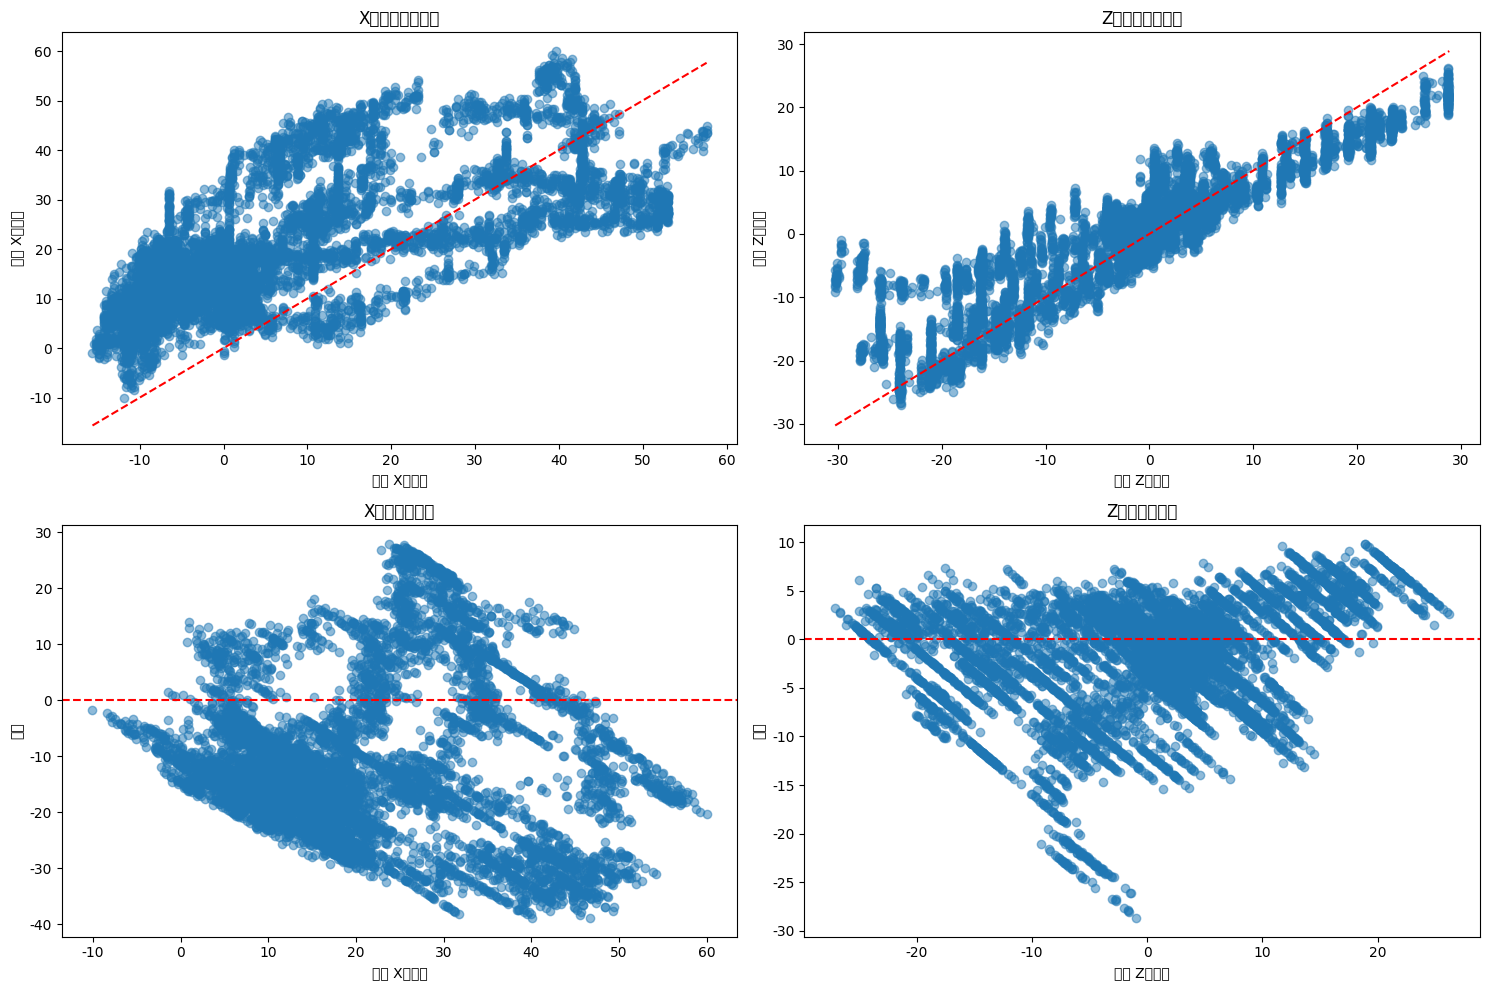

  ▶ 模型: random_forest

=== 準備特徵資料 ===
輸入特徵數量: 25
時間特徵 (1): ['Time']
位置溫度特徵 (21): ['PT01', 'PT02', 'PT03', 'PT04', 'PT05', 'PT06', 'PT07', 'PT08', 'PT09', 'PT10', 'PT11', 'PT12', 'PT13', 'TC01', 'TC02', 'TC03', 'TC04', 'TC05', 'TC06', 'TC07', 'TC08']
馬達溫度特徵 (3): ['Spindle Motor', 'X Motor', 'Z Motor']

=== 處理缺失資料 ===
各欄位缺失值數量:
Series([], dtype: int64)
處理後剩餘缺失值數量: 0

=== 訓練模型 (random_forest) ===
訓練 X軸變位預測模型...
訓練 Z軸變位預測模型...


findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

模型訓練完成！

=== 模型評估 ===
整體 X軸變位 RMSE: 23.006437
整體 Z軸變位 RMSE: 9.931149
整體平均 RMSE: 16.468793
X軸變位 R²: -0.515731
Z軸變位 R²: 0.397580

=== 分區RMSE分析 ===

1. 按變位大小分區:
  X軸 P0-P25: RMSE=17.8677, 樣本數=2185
  X軸 P25-P50: RMSE=17.6046, 樣本數=2171
  X軸 P50-P75: RMSE=29.2123, 樣本數=2201
  X軸 P75-P100: RMSE=25.1162, 樣本數=2186
  Z軸 P0-P25: RMSE=16.6676, 樣本數=2183
  Z軸 P25-P50: RMSE=6.0615, 樣本數=2171
  Z軸 P50-P75: RMSE=3.8899, 樣本數=2203
  Z軸 P75-P100: RMSE=8.0808, 樣本數=2186

2. 按主軸馬達溫度分區:
  X軸 低溫區間: RMSE=18.1548, 樣本數=2581
  X軸 中溫區間: RMSE=30.1033, 樣本數=2721
  X軸 高溫區間: RMSE=19.5202, 樣本數=3441
  Z軸 低溫區間: RMSE=9.6662, 樣本數=2581
  Z軸 中溫區間: RMSE=13.0156, 樣本數=2721
  Z軸 高溫區間: RMSE=6.8230, 樣本數=3441

3. 按時間分區:
  X軸 初期: RMSE=10.0763, 樣本數=2186
  X軸 前期: RMSE=15.3121, 樣本數=2185
  X軸 中期: RMSE=29.6105, 樣本數=2186
  X軸 後期: RMSE=30.0712, 樣本數=2186
  Z軸 初期: RMSE=3.5290, 樣本數=2186
  Z軸 前期: RMSE=8.7818, 樣本數=2185
  Z軸 中期: RMSE=11.0980, 樣本數=2186
  Z軸 後期: RMSE=13.4819, 樣本數=2186

4. 極端值分析:
  X軸極端情況 (誤差>P95): RMSE=59.4627, 最大誤差=66.3751, 樣本數=438
 

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

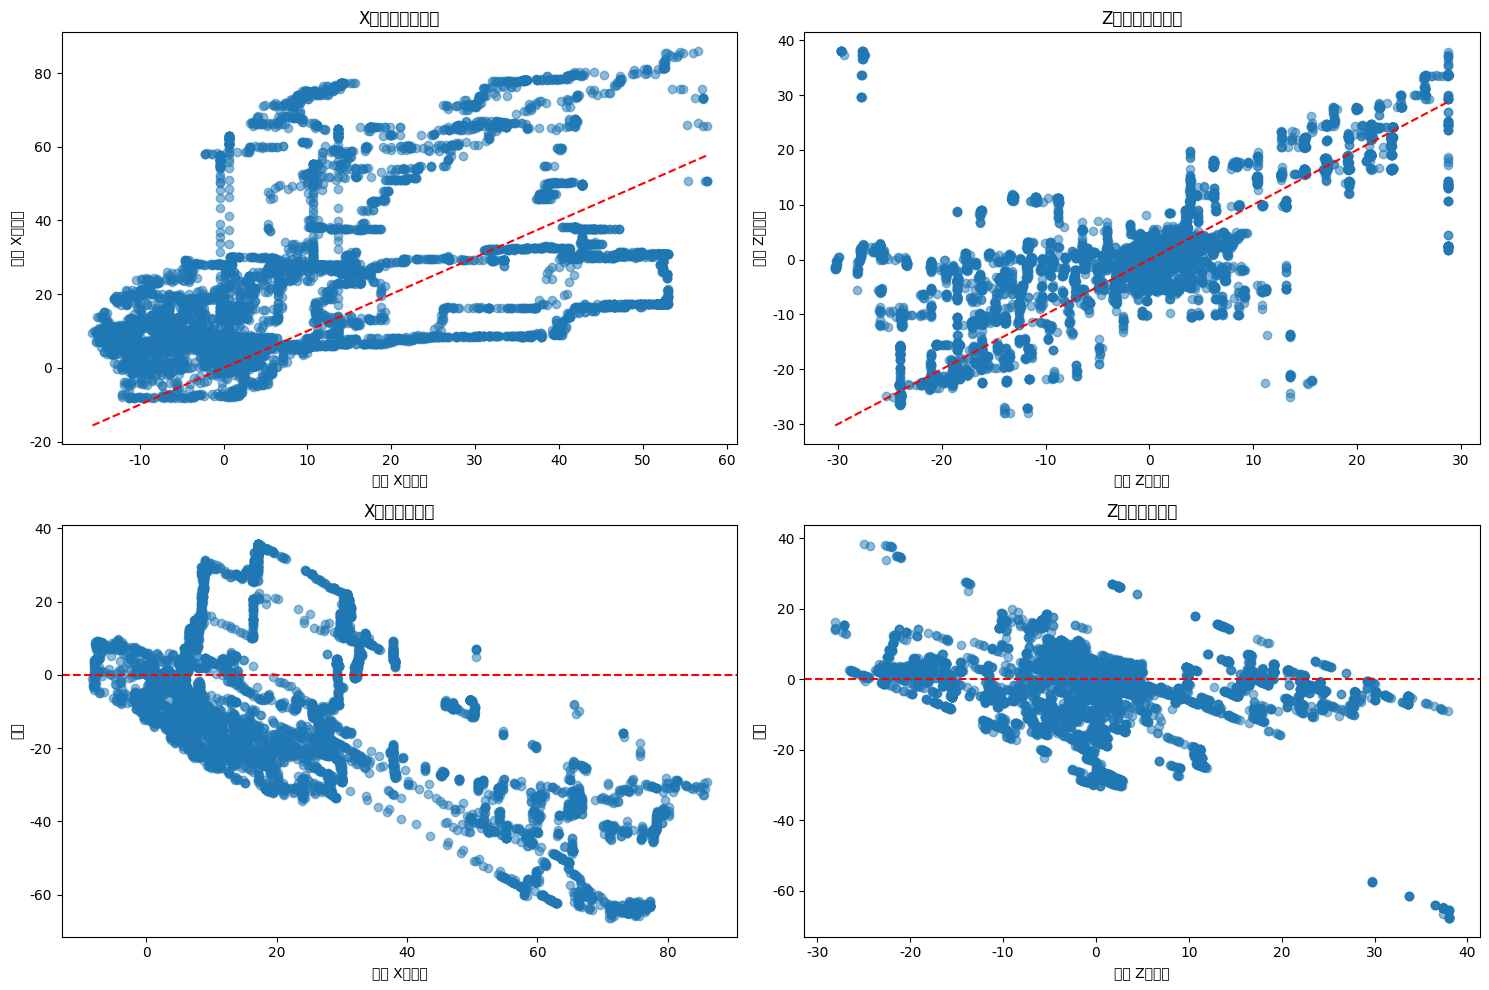

  ▶ 模型: gradient_boosting

=== 準備特徵資料 ===
輸入特徵數量: 25
時間特徵 (1): ['Time']
位置溫度特徵 (21): ['PT01', 'PT02', 'PT03', 'PT04', 'PT05', 'PT06', 'PT07', 'PT08', 'PT09', 'PT10', 'PT11', 'PT12', 'PT13', 'TC01', 'TC02', 'TC03', 'TC04', 'TC05', 'TC06', 'TC07', 'TC08']
馬達溫度特徵 (3): ['Spindle Motor', 'X Motor', 'Z Motor']

=== 處理缺失資料 ===
各欄位缺失值數量:
Series([], dtype: int64)
處理後剩餘缺失值數量: 0

=== 訓練模型 (gradient_boosting) ===
訓練 X軸變位預測模型...
訓練 Z軸變位預測模型...


findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

模型訓練完成！

=== 模型評估 ===
整體 X軸變位 RMSE: 24.038661
整體 Z軸變位 RMSE: 8.470057
整體平均 RMSE: 16.254359
X軸變位 R²: -0.654794
Z軸變位 R²: 0.561799

=== 分區RMSE分析 ===

1. 按變位大小分區:
  X軸 P0-P25: RMSE=20.1807, 樣本數=2185
  X軸 P25-P50: RMSE=19.3017, 樣本數=2171
  X軸 P50-P75: RMSE=31.2085, 樣本數=2201
  X軸 P75-P100: RMSE=23.5253, 樣本數=2186
  Z軸 P0-P25: RMSE=13.9628, 樣本數=2183
  Z軸 P25-P50: RMSE=4.5675, 樣本數=2171
  Z軸 P50-P75: RMSE=3.4812, 樣本數=2203
  Z軸 P75-P100: RMSE=7.7013, 樣本數=2186

2. 按主軸馬達溫度分區:
  X軸 低溫區間: RMSE=19.5109, 樣本數=2581
  X軸 中溫區間: RMSE=32.7227, 樣本數=2721
  X軸 高溫區間: RMSE=18.3297, 樣本數=3441
  Z軸 低溫區間: RMSE=9.8030, 樣本數=2581
  Z軸 中溫區間: RMSE=8.6939, 樣本數=2721
  Z軸 高溫區間: RMSE=7.1018, 樣本數=3441

3. 按時間分區:
  X軸 初期: RMSE=11.9880, 樣本數=2186
  X軸 前期: RMSE=16.7489, 樣本數=2185
  X軸 中期: RMSE=28.9093, 樣本數=2186
  X軸 後期: RMSE=32.4238, 樣本數=2186
  Z軸 初期: RMSE=3.5058, 樣本數=2186
  Z軸 前期: RMSE=9.3532, 樣本數=2185
  Z軸 中期: RMSE=9.8815, 樣本數=2186
  Z軸 後期: RMSE=9.4635, 樣本數=2186

4. 極端值分析:
  X軸極端情況 (誤差>P95): RMSE=62.0407, 最大誤差=72.1660, 樣本數=438
    

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

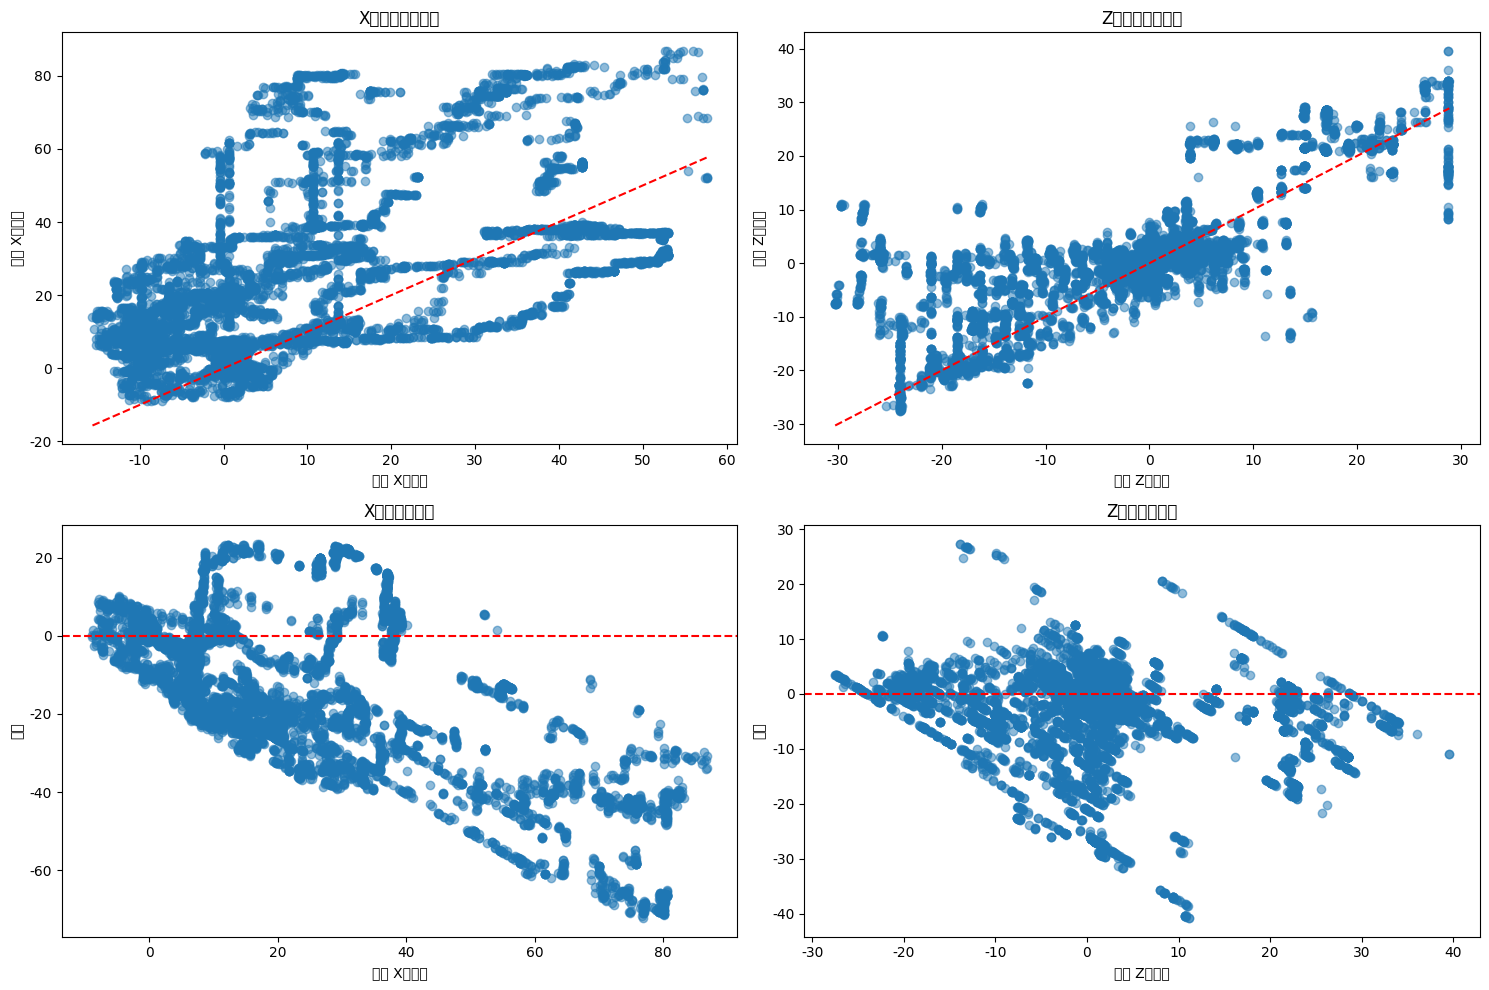

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 


[5H] 策略: environment_split (train=29, test=14)
  ▶ 模型: linear

=== 準備特徵資料 ===
輸入特徵數量: 25
時間特徵 (1): ['Time']
位置溫度特徵 (21): ['PT01', 'PT02', 'PT03', 'PT04', 'PT05', 'PT06', 'PT07', 'PT08', 'PT09', 'PT10', 'PT11', 'PT12', 'PT13', 'TC01', 'TC02', 'TC03', 'TC04', 'TC05', 'TC06', 'TC07', 'TC08']
馬達溫度特徵 (3): ['Spindle Motor', 'X Motor', 'Z Motor']

=== 處理缺失資料 ===
各欄位缺失值數量:
Series([], dtype: int64)
處理後剩餘缺失值數量: 0

=== 訓練模型 (linear) ===
訓練 X軸變位預測模型...
訓練 Z軸變位預測模型...
模型訓練完成！

=== 模型評估 ===
整體 X軸變位 RMSE: 20.980134
整體 Z軸變位 RMSE: 5.288068
整體平均 RMSE: 13.134101
X軸變位 R²: -0.274650
Z軸變位 R²: 0.863624

=== 分區RMSE分析 ===

1. 按變位大小分區:
  X軸 P0-P25: RMSE=11.3778, 樣本數=2490
  X軸 P25-P50: RMSE=13.9910, 樣本數=2509
  X軸 P50-P75: RMSE=17.8192, 樣本數=2508
  X軸 P75-P100: RMSE=33.3876, 樣本數=2512
  Z軸 P0-P25: RMSE=6.5699, 樣本數=2499
  Z軸 P25-P50: RMSE=4.2776, 樣本數=2462
  Z軸 P50-P75: RMSE=3.0743, 樣本數=2550
  Z軸 P75-P100: RMSE=6.4132, 樣本數=2508

2. 按主軸馬達溫度分區:
  X軸 低溫區間: RMSE=8.8360, 樣本數=2951
  X軸 中溫區間: RMSE=25.0738, 樣本數=3500
  X軸 高溫

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

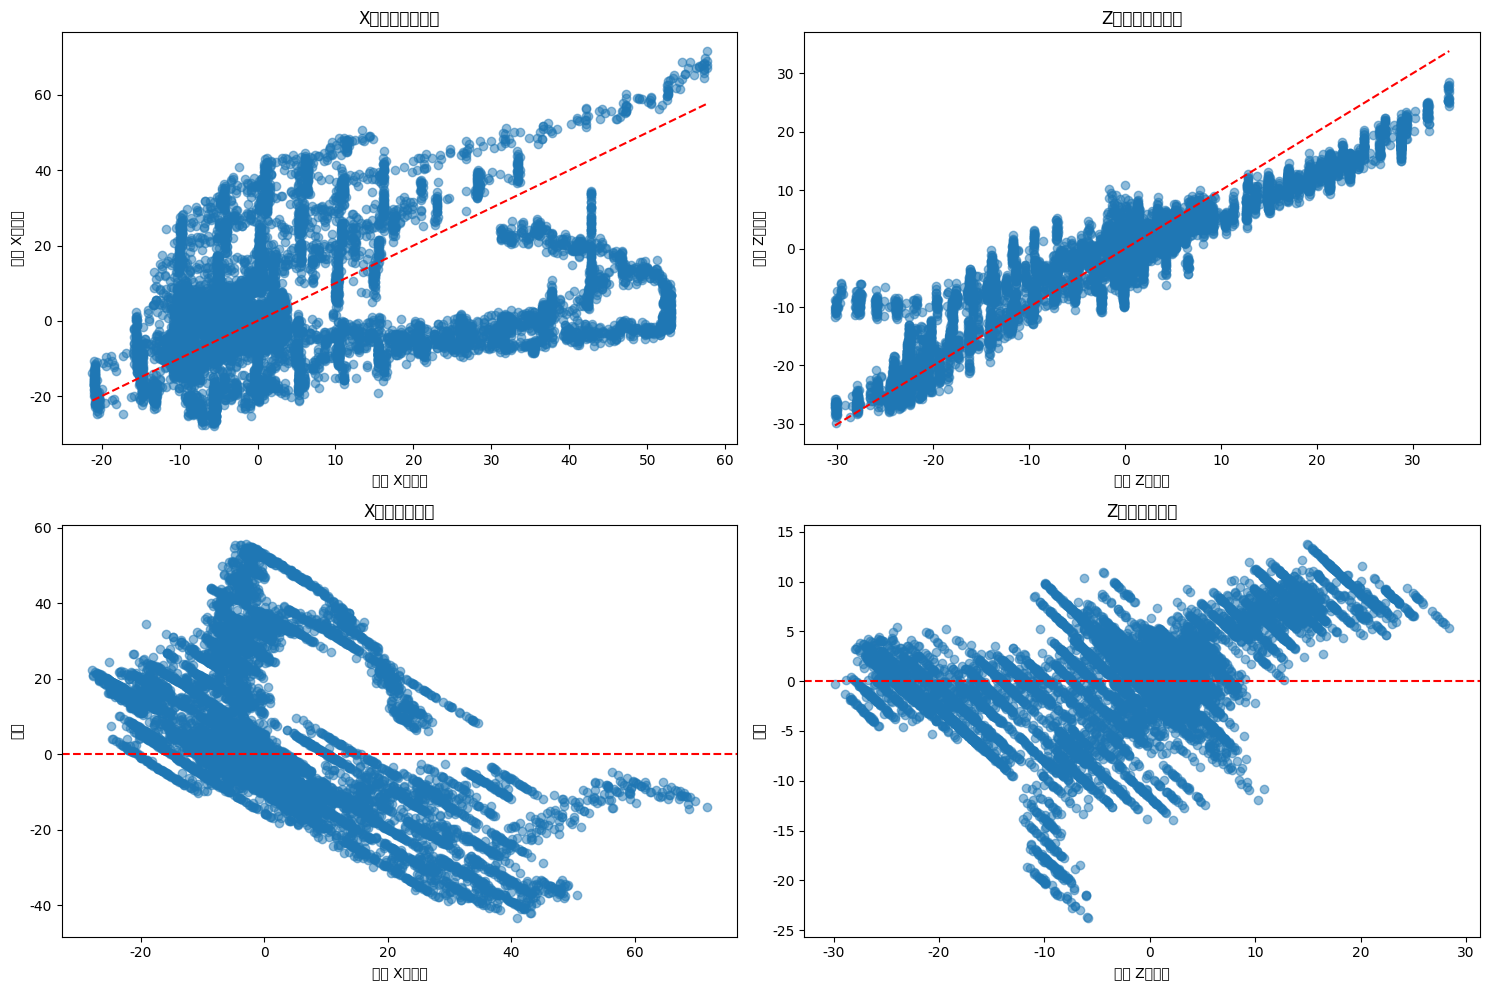

  ▶ 模型: random_forest

=== 準備特徵資料 ===
輸入特徵數量: 25
時間特徵 (1): ['Time']
位置溫度特徵 (21): ['PT01', 'PT02', 'PT03', 'PT04', 'PT05', 'PT06', 'PT07', 'PT08', 'PT09', 'PT10', 'PT11', 'PT12', 'PT13', 'TC01', 'TC02', 'TC03', 'TC04', 'TC05', 'TC06', 'TC07', 'TC08']
馬達溫度特徵 (3): ['Spindle Motor', 'X Motor', 'Z Motor']

=== 處理缺失資料 ===
各欄位缺失值數量:
Series([], dtype: int64)
處理後剩餘缺失值數量: 0

=== 訓練模型 (random_forest) ===
訓練 X軸變位預測模型...
訓練 Z軸變位預測模型...


findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

模型訓練完成！

=== 模型評估 ===
整體 X軸變位 RMSE: 18.179905
整體 Z軸變位 RMSE: 10.349666
整體平均 RMSE: 14.264785
X軸變位 R²: 0.042900
Z軸變位 R²: 0.477606

=== 分區RMSE分析 ===

1. 按變位大小分區:
  X軸 P0-P25: RMSE=11.8052, 樣本數=2490
  X軸 P25-P50: RMSE=13.2207, 樣本數=2509
  X軸 P50-P75: RMSE=16.2002, 樣本數=2508
  X軸 P75-P100: RMSE=27.2667, 樣本數=2512
  Z軸 P0-P25: RMSE=9.7158, 樣本數=2499
  Z軸 P25-P50: RMSE=6.5929, 樣本數=2462
  Z軸 P50-P75: RMSE=6.8781, 樣本數=2550
  Z軸 P75-P100: RMSE=15.5910, 樣本數=2508

2. 按主軸馬達溫度分區:
  X軸 低溫區間: RMSE=10.4546, 樣本數=2951
  X軸 中溫區間: RMSE=25.8749, 樣本數=3500
  X軸 高溫區間: RMSE=13.4510, 樣本數=3568
  Z軸 低溫區間: RMSE=5.3988, 樣本數=2951
  Z軸 中溫區間: RMSE=14.3107, 樣本數=3500
  Z軸 高溫區間: RMSE=8.7053, 樣本數=3568

3. 按時間分區:
  X軸 初期: RMSE=3.1844, 樣本數=2505
  X軸 前期: RMSE=11.8709, 樣本數=2504
  X軸 中期: RMSE=25.7550, 樣本數=2505
  X軸 後期: RMSE=22.5295, 樣本數=2505
  Z軸 初期: RMSE=3.9249, 樣本數=2505
  Z軸 前期: RMSE=6.7475, 樣本數=2504
  Z軸 中期: RMSE=12.1519, 樣本數=2505
  Z軸 後期: RMSE=14.8268, 樣本數=2505

4. 極端值分析:
  X軸極端情況 (誤差>P95): RMSE=50.8164, 最大誤差=65.7112, 樣本數=501
  

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

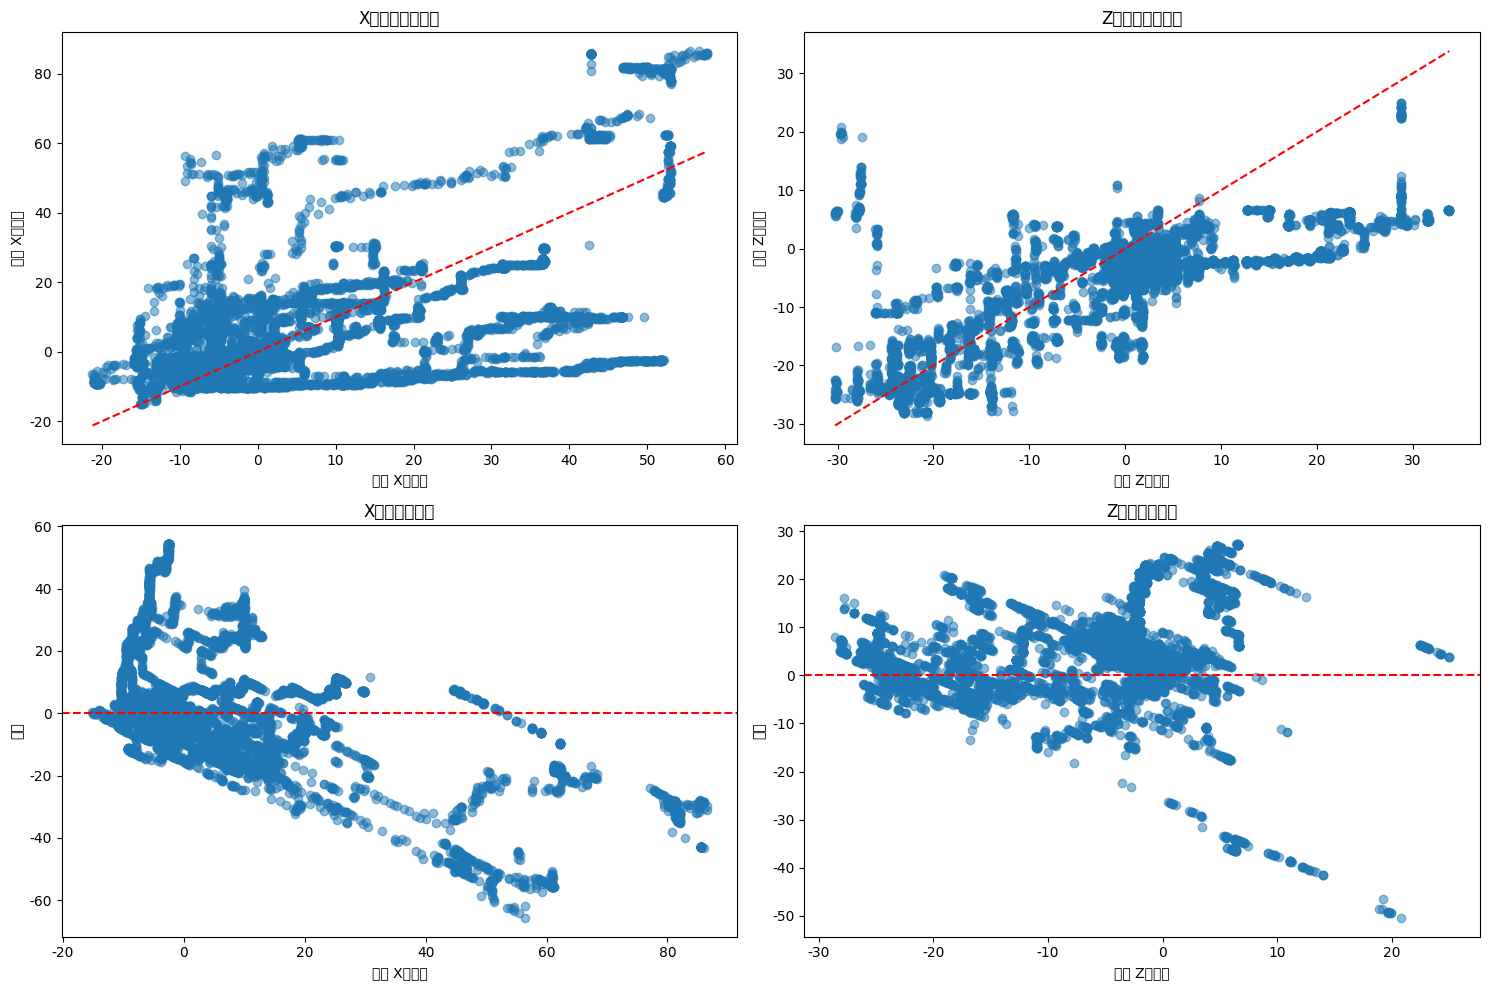

  ▶ 模型: gradient_boosting

=== 準備特徵資料 ===
輸入特徵數量: 25
時間特徵 (1): ['Time']
位置溫度特徵 (21): ['PT01', 'PT02', 'PT03', 'PT04', 'PT05', 'PT06', 'PT07', 'PT08', 'PT09', 'PT10', 'PT11', 'PT12', 'PT13', 'TC01', 'TC02', 'TC03', 'TC04', 'TC05', 'TC06', 'TC07', 'TC08']
馬達溫度特徵 (3): ['Spindle Motor', 'X Motor', 'Z Motor']

=== 處理缺失資料 ===
各欄位缺失值數量:
Series([], dtype: int64)
處理後剩餘缺失值數量: 0

=== 訓練模型 (gradient_boosting) ===
訓練 X軸變位預測模型...
訓練 Z軸變位預測模型...


findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

模型訓練完成！

=== 模型評估 ===
整體 X軸變位 RMSE: 16.397452
整體 Z軸變位 RMSE: 9.525641
整體平均 RMSE: 12.961547
X軸變位 R²: 0.221377
Z軸變位 R²: 0.557479

=== 分區RMSE分析 ===

1. 按變位大小分區:
  X軸 P0-P25: RMSE=11.1854, 樣本數=2490
  X軸 P25-P50: RMSE=11.5970, 樣本數=2509
  X軸 P50-P75: RMSE=13.8123, 樣本數=2508
  X軸 P75-P100: RMSE=24.9715, 樣本數=2512
  Z軸 P0-P25: RMSE=7.9465, 樣本數=2499
  Z軸 P25-P50: RMSE=5.0973, 樣本數=2462
  Z軸 P50-P75: RMSE=6.9666, 樣本數=2550
  Z軸 P75-P100: RMSE=14.9903, 樣本數=2508

2. 按主軸馬達溫度分區:
  X軸 低溫區間: RMSE=10.9690, 樣本數=2951
  X軸 中溫區間: RMSE=22.4786, 樣本數=3500
  X軸 高溫區間: RMSE=12.6428, 樣本數=3568
  Z軸 低溫區間: RMSE=5.0184, 樣本數=2951
  Z軸 中溫區間: RMSE=12.9783, 樣本數=3500
  Z軸 高溫區間: RMSE=8.2908, 樣本數=3568

3. 按時間分區:
  X軸 初期: RMSE=3.2516, 樣本數=2505
  X軸 前期: RMSE=10.9007, 樣本數=2504
  X軸 中期: RMSE=24.0706, 樣本數=2505
  X軸 後期: RMSE=19.1483, 樣本數=2505
  Z軸 初期: RMSE=3.7667, 樣本數=2505
  Z軸 前期: RMSE=6.8833, 樣本數=2504
  Z軸 中期: RMSE=11.3123, 樣本數=2505
  Z軸 後期: RMSE=13.1681, 樣本數=2505

4. 極端值分析:
  X軸極端情況 (誤差>P95): RMSE=44.7976, 最大誤差=52.6648, 樣本數=507
   

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

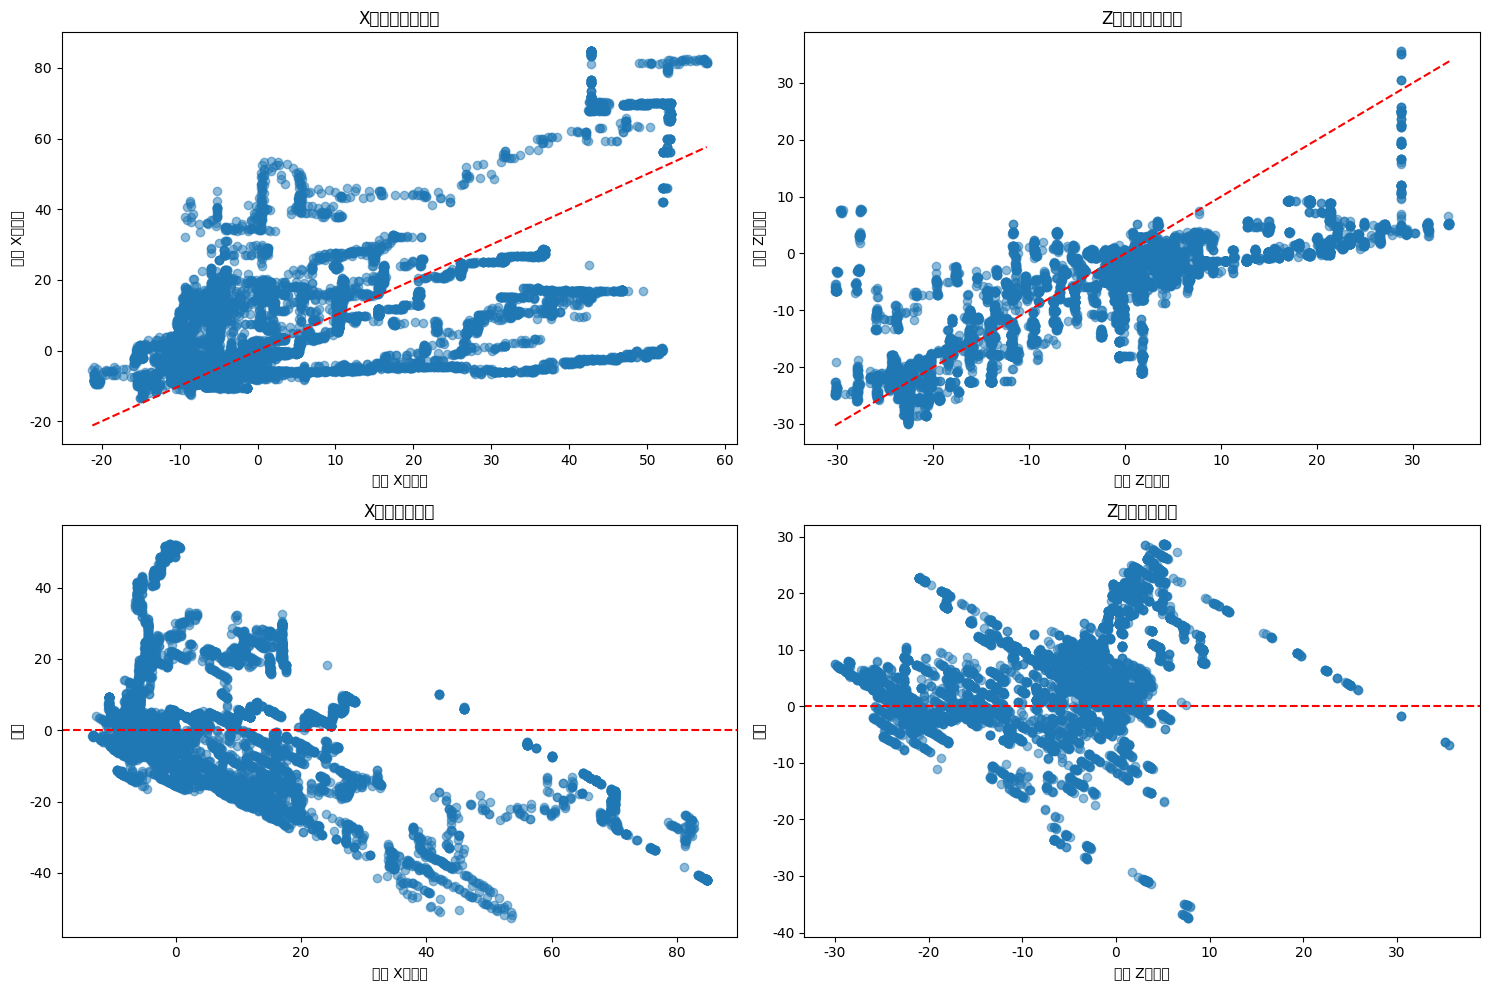

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 


[5H] 策略: few_shot_split (train=17, test=26)
  ▶ 模型: linear

=== 準備特徵資料 ===
輸入特徵數量: 25
時間特徵 (1): ['Time']
位置溫度特徵 (21): ['PT01', 'PT02', 'PT03', 'PT04', 'PT05', 'PT06', 'PT07', 'PT08', 'PT09', 'PT10', 'PT11', 'PT12', 'PT13', 'TC01', 'TC02', 'TC03', 'TC04', 'TC05', 'TC06', 'TC07', 'TC08']
馬達溫度特徵 (3): ['Spindle Motor', 'X Motor', 'Z Motor']

=== 處理缺失資料 ===
各欄位缺失值數量:
Series([], dtype: int64)
處理後剩餘缺失值數量: 0

=== 訓練模型 (linear) ===
訓練 X軸變位預測模型...
訓練 Z軸變位預測模型...
模型訓練完成！

=== 模型評估 ===
整體 X軸變位 RMSE: 11.872776
整體 Z軸變位 RMSE: 6.837488
整體平均 RMSE: 9.355132
X軸變位 R²: 0.524017
Z軸變位 R²: 0.719583

=== 分區RMSE分析 ===

1. 按變位大小分區:
  X軸 P0-P25: RMSE=8.5779, 樣本數=4047
  X軸 P25-P50: RMSE=9.5225, 樣本數=4017
  X軸 P50-P75: RMSE=15.3929, 樣本數=4075
  X軸 P75-P100: RMSE=12.7095, 樣本數=4063
  Z軸 P0-P25: RMSE=6.3652, 樣本數=4049
  Z軸 P25-P50: RMSE=5.2317, 樣本數=4021
  Z軸 P50-P75: RMSE=3.7756, 樣本數=4059
  Z軸 P75-P100: RMSE=10.2209, 樣本數=4073

2. 按主軸馬達溫度分區:
  X軸 低溫區間: RMSE=8.0759, 樣本數=4672
  X軸 中溫區間: RMSE=11.2883, 樣本數=5443
  X軸 高溫區間: RM

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

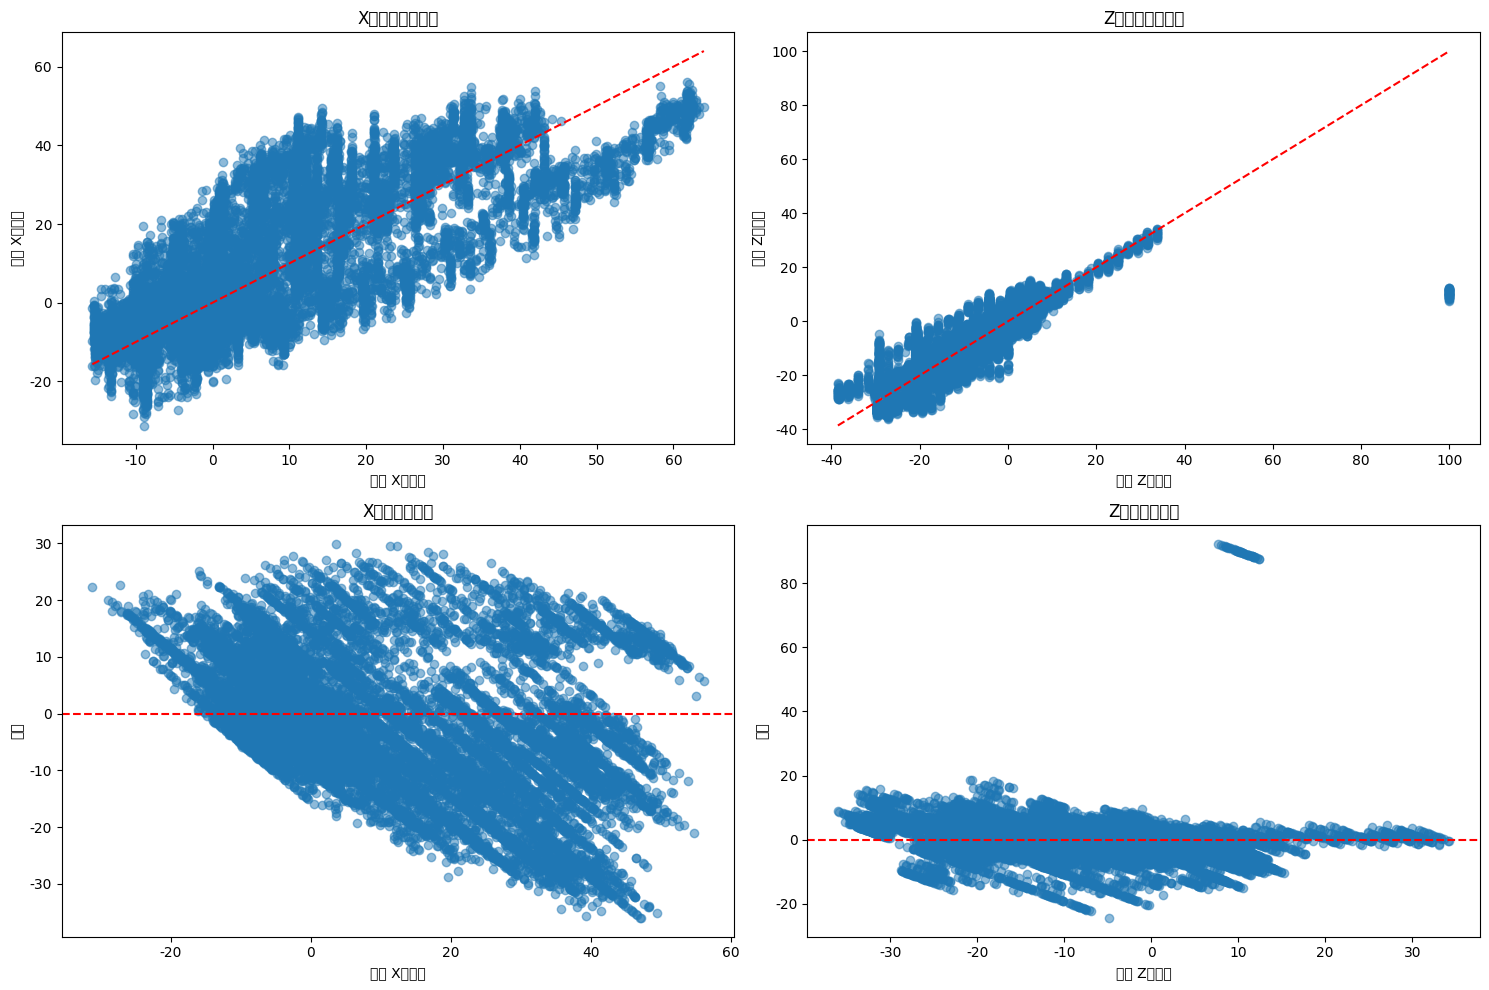

  ▶ 模型: random_forest

=== 準備特徵資料 ===
輸入特徵數量: 25
時間特徵 (1): ['Time']
位置溫度特徵 (21): ['PT01', 'PT02', 'PT03', 'PT04', 'PT05', 'PT06', 'PT07', 'PT08', 'PT09', 'PT10', 'PT11', 'PT12', 'PT13', 'TC01', 'TC02', 'TC03', 'TC04', 'TC05', 'TC06', 'TC07', 'TC08']
馬達溫度特徵 (3): ['Spindle Motor', 'X Motor', 'Z Motor']

=== 處理缺失資料 ===
各欄位缺失值數量:
Series([], dtype: int64)
處理後剩餘缺失值數量: 0

=== 訓練模型 (random_forest) ===
訓練 X軸變位預測模型...
訓練 Z軸變位預測模型...


findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

模型訓練完成！

=== 模型評估 ===
整體 X軸變位 RMSE: 19.365045
整體 Z軸變位 RMSE: 14.883017
整體平均 RMSE: 17.124031
X軸變位 R²: -0.266262
Z軸變位 R²: -0.328597

=== 分區RMSE分析 ===

1. 按變位大小分區:
  X軸 P0-P25: RMSE=7.9401, 樣本數=4047
  X軸 P25-P50: RMSE=14.7360, 樣本數=4017
  X軸 P50-P75: RMSE=23.6183, 樣本數=4075
  X軸 P75-P100: RMSE=25.6602, 樣本數=4063
  Z軸 P0-P25: RMSE=14.3314, 樣本數=4049
  Z軸 P25-P50: RMSE=11.1396, 樣本數=4021
  Z軸 P50-P75: RMSE=10.6202, 樣本數=4059
  Z軸 P75-P100: RMSE=21.0247, 樣本數=4073

2. 按主軸馬達溫度分區:
  X軸 低溫區間: RMSE=18.5280, 樣本數=4672
  X軸 中溫區間: RMSE=19.5214, 樣本數=5443
  X軸 高溫區間: RMSE=19.8473, 樣本數=6087
  Z軸 低溫區間: RMSE=8.9636, 樣本數=4672
  Z軸 中溫區間: RMSE=20.3191, 樣本數=5443
  Z軸 高溫區間: RMSE=12.5989, 樣本數=6087

3. 按時間分區:
  X軸 初期: RMSE=5.6765, 樣本數=4051
  X軸 前期: RMSE=13.6801, 樣本數=4050
  X軸 中期: RMSE=23.7686, 樣本數=4050
  X軸 後期: RMSE=26.7526, 樣本數=4051
  Z軸 初期: RMSE=6.4871, 樣本數=4051
  Z軸 前期: RMSE=13.4715, 樣本數=4050
  Z軸 中期: RMSE=16.3185, 樣本數=4050
  Z軸 後期: RMSE=19.9038, 樣本數=4051

4. 極端值分析:
  X軸極端情況 (誤差>P95): RMSE=56.0874, 最大誤差=69.2604, 樣本數=

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

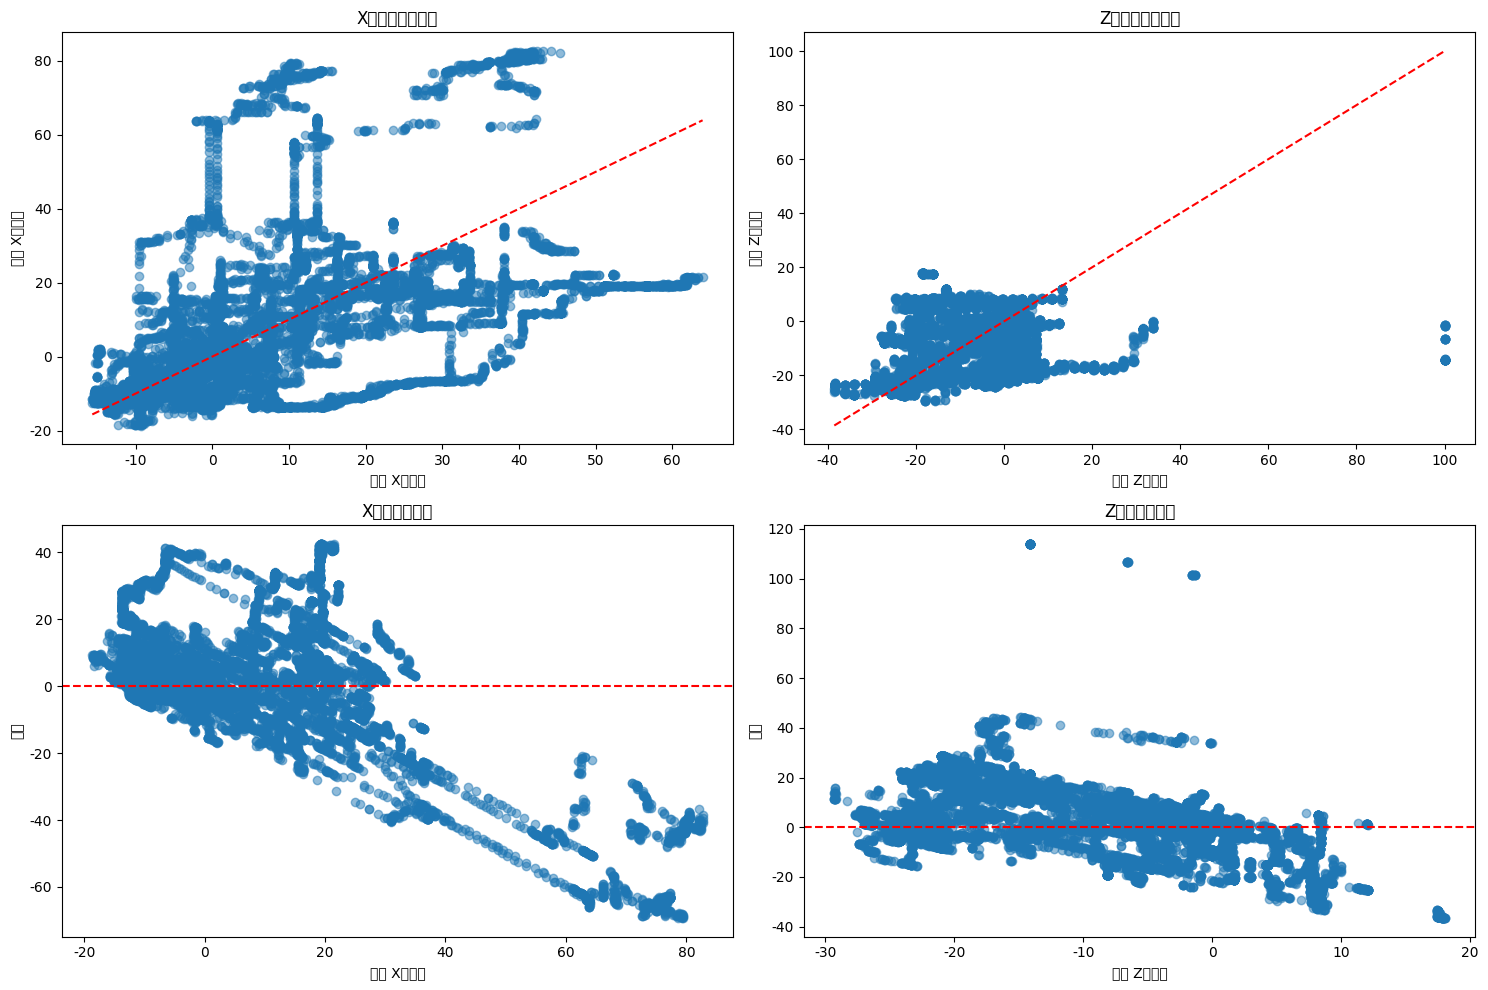

  ▶ 模型: gradient_boosting

=== 準備特徵資料 ===
輸入特徵數量: 25
時間特徵 (1): ['Time']
位置溫度特徵 (21): ['PT01', 'PT02', 'PT03', 'PT04', 'PT05', 'PT06', 'PT07', 'PT08', 'PT09', 'PT10', 'PT11', 'PT12', 'PT13', 'TC01', 'TC02', 'TC03', 'TC04', 'TC05', 'TC06', 'TC07', 'TC08']
馬達溫度特徵 (3): ['Spindle Motor', 'X Motor', 'Z Motor']

=== 處理缺失資料 ===
各欄位缺失值數量:
Series([], dtype: int64)
處理後剩餘缺失值數量: 0

=== 訓練模型 (gradient_boosting) ===
訓練 X軸變位預測模型...
訓練 Z軸變位預測模型...


findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

模型訓練完成！

=== 模型評估 ===
整體 X軸變位 RMSE: 18.420783
整體 Z軸變位 RMSE: 14.291377
整體平均 RMSE: 16.356080
X軸變位 R²: -0.145784
Z軸變位 R²: -0.225066

=== 分區RMSE分析 ===

1. 按變位大小分區:
  X軸 P0-P25: RMSE=6.5270, 樣本數=4047
  X軸 P25-P50: RMSE=13.7091, 樣本數=4017
  X軸 P50-P75: RMSE=22.6774, 樣本數=4075
  X軸 P75-P100: RMSE=24.6799, 樣本數=4063
  Z軸 P0-P25: RMSE=15.0642, 樣本數=4049
  Z軸 P25-P50: RMSE=11.0060, 樣本數=4021
  Z軸 P50-P75: RMSE=9.3967, 樣本數=4059
  Z軸 P75-P100: RMSE=19.4753, 樣本數=4073

2. 按主軸馬達溫度分區:
  X軸 低溫區間: RMSE=16.9958, 樣本數=4672
  X軸 中溫區間: RMSE=18.9506, 樣本數=5443
  X軸 高溫區間: RMSE=18.9830, 樣本數=6087
  Z軸 低溫區間: RMSE=9.2957, 樣本數=4672
  Z軸 中溫區間: RMSE=18.3690, 樣本數=5443
  Z軸 高溫區間: RMSE=13.2514, 樣本數=6087

3. 按時間分區:
  X軸 初期: RMSE=5.5622, 樣本數=4051
  X軸 前期: RMSE=12.6049, 樣本數=4050
  X軸 中期: RMSE=21.6119, 樣本數=4050
  X軸 後期: RMSE=26.4649, 樣本數=4051
  Z軸 初期: RMSE=5.7533, 樣本數=4051
  Z軸 前期: RMSE=12.8197, 樣本數=4050
  Z軸 中期: RMSE=15.9051, 樣本數=4050
  Z軸 後期: RMSE=19.1457, 樣本數=4051

4. 極端值分析:
  X軸極端情況 (誤差>P95): RMSE=54.9786, 最大誤差=71.5259, 樣本數=8

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

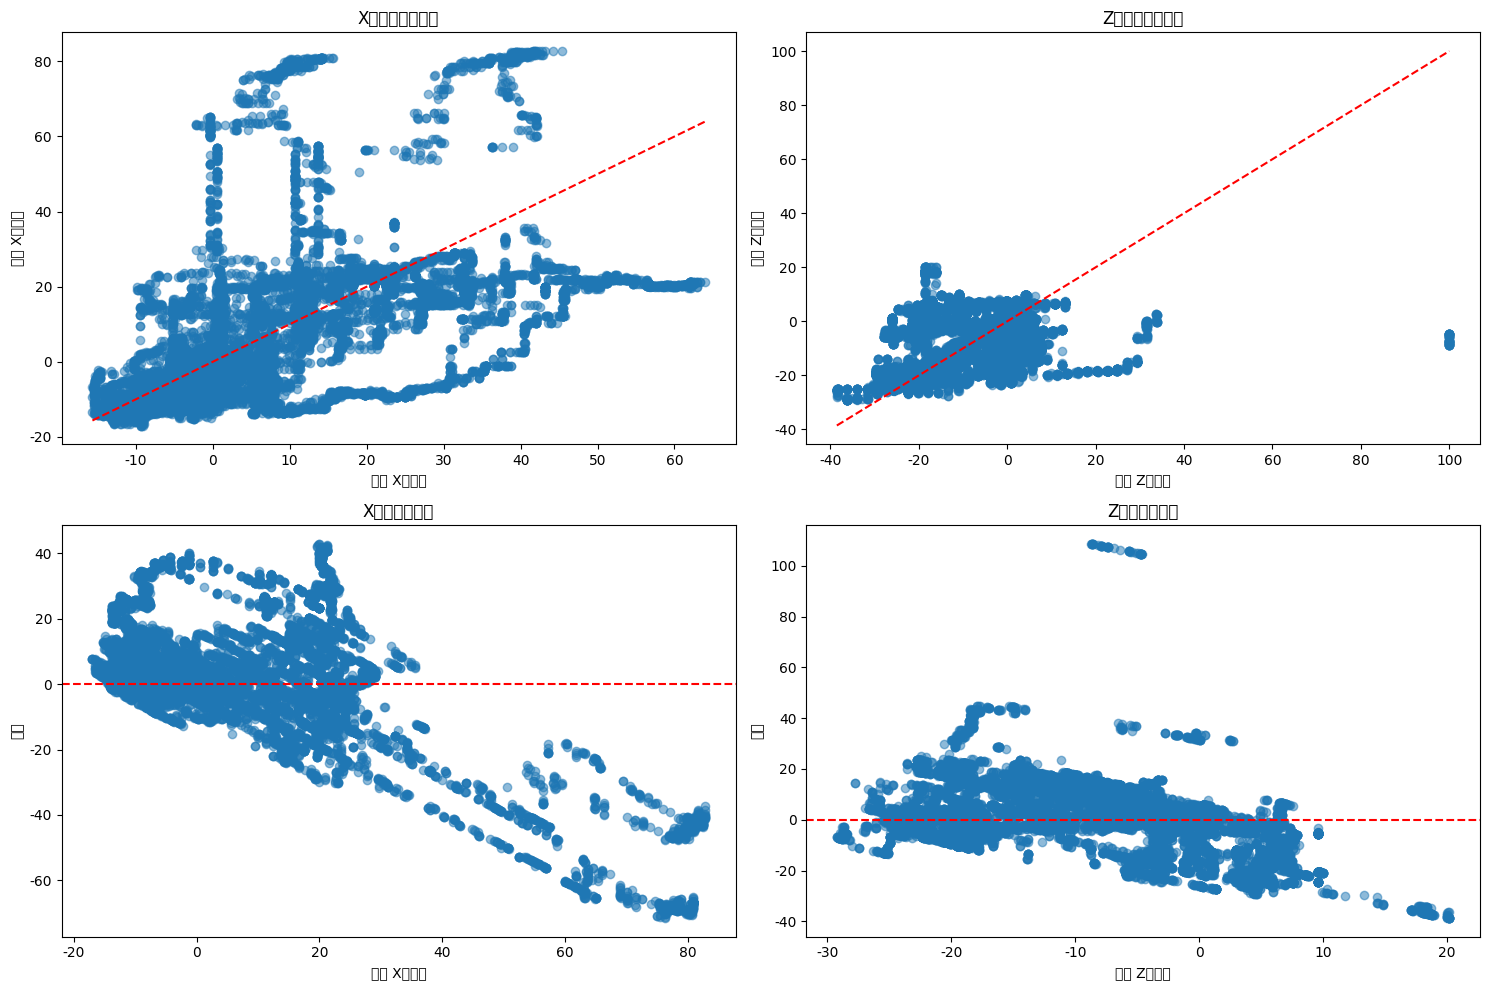


[5H] 全部結果 (依 avg_rmse 排序):
            strategy              model     rmse_X     rmse_Z   avg_rmse
6     few_shot_split             linear  11.872776   6.837488   9.355132
0         time_split             linear  17.598605   5.703033  11.650819
5  environment_split  gradient_boosting  16.397452   9.525641  12.961547
3  environment_split             linear  20.980134   5.288068  13.134101
4  environment_split      random_forest  18.179905  10.349666  14.264785
2         time_split  gradient_boosting  24.038661   8.470057  16.254359
8     few_shot_split  gradient_boosting  18.420783  14.291377  16.356080
1         time_split      random_forest  23.006437   9.931149  16.468793
7     few_shot_split      random_forest  19.365045  14.883017  17.124031

Saved: results_summary_5h.csv, best_per_strategy_5h.csv, overall_best_5h.json

[5H] Best per strategy:
            strategy              model     rmse_X    rmse_Z   avg_rmse
0  environment_split  gradient_boosting  16.397452  9.525641  12.9

In [59]:
# === Re-run with 5H truncated dataset ===
from pathlib import Path
print('Switching to 5H dataset...')
BASE_DATA_DIR_5H = '/Users/benjamin/1132/11325/AI_Race/truncated_data_5h'
assert Path(BASE_DATA_DIR_5H).exists(), 'truncated_data_5h not found, run the truncation cell first.'

all_files_df_5h = list_data_files(BASE_DATA_DIR_5H)
print(f'5H 檔案數: {len(all_files_df_5h)}')

# Recompute splits on 5H data
time_train_5h, time_test_5h = time_based_split(all_files_df_5h, 0.7)
env_train_5h, env_test_5h = environment_based_split(all_files_df_5h)
few_train_5h, few_test_5h = few_shot_split(all_files_df_5h, K=1)

strategies_5h = {
    'time_split': (time_train_5h, time_test_5h),
    'environment_split': (env_train_5h, env_test_5h),
    'few_shot_split': (few_train_5h, few_test_5h)
}

results_records_5h = []
for strat_name, (tr_df, te_df) in strategies_5h.items():
    train_files = tr_df['file_path'].tolist()
    test_files = te_df['file_path'].tolist()
    print('\n' + '='*60)
    print(f'[5H] 策略: {strat_name} (train={len(train_files)}, test={len(test_files)})')
    for m in models:
        print(f'  ▶ 模型: {m}')
        res = train_and_evaluate_with_custom_split(train_files, test_files, model_type=m)
        results_records_5h.append({
            'strategy': strat_name,
            'model': m,
            'rmse_X': res['rmse_X'],
            'rmse_Z': res['rmse_Z'],
            'avg_rmse': res['avg_rmse']
        })

results_5h_df = pd.DataFrame(results_records_5h)
print('\n[5H] 全部結果 (依 avg_rmse 排序):')
print(results_5h_df.sort_values('avg_rmse'))

best_5h_per_strategy = results_5h_df.loc[results_5h_df.groupby('strategy')['avg_rmse'].idxmin()].reset_index(drop=True)
overall_best_5h = results_5h_df.sort_values('avg_rmse').iloc[0]

# Save separate files
results_5h_df.to_csv(f'{EXPERIMENT_ROOT}/results_summary_5h.csv', index=False)
best_5h_per_strategy.to_csv(f'{EXPERIMENT_ROOT}/best_per_strategy_5h.csv', index=False)
overall_best_5h.to_json(f'{EXPERIMENT_ROOT}/overall_best_5h.json')
print('\nSaved: results_summary_5h.csv, best_per_strategy_5h.csv, overall_best_5h.json')
print('\n[5H] Best per strategy:')
print(best_5h_per_strategy)
print('\n[5H] Overall best:')
print(overall_best_5h)

## 後續可改進方向
- 加入更多特徵工程 (差分、移動平均、溫度梯度等)
- Few-Shot 可嘗試 meta-learning / fine-tuning 架構
- 環境切分可嘗試 domain adaptation 技術
- 時間切分可強化為滑動視窗 + 序列模型 (LSTM, Transformer)
- 增加誤差來源診斷 (Error Attribution)

> 若需將此結果輸出成報告或整合 README，可再提出需求。